In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

In [2]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings
# from scipy.optimize import curve_fit
from tqdm import tqdm_notebook

class AetasStellae():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989
    '''
    def __init__(self,FeH,CNAlpha,Distance,Rv,Isochrones):
        
        '''
        FeH: [float] metallicity [Fe/H] of star
        CNAlpha: [array] [C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe]
        Distance: [float] distance to star in pc
        Isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # Salaris Correction
        self.salfeh = self.SalarisCorrectedFeH(FeH,CNAlpha)
        
        # Distance modulus
        self.distmod = 5.0*np.log10(Distance)-5.0
        
        # PARSEC isochrones
        self.rv = Rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(Isochrones['logAge'])
        self.iso = Isochrones[np.where(Isochrones['MH']==self.closest(Isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    def SalarisCorrectedFeH(self,feh,cnalpha):
        '''
        Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
        Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
        Inputs:
        ------
            feh: metallcity of a star
            cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
        Output:
        ------
            
        '''
        # hydrogen_wgt = 1.008 #IUPAC
        # atomic_wgts = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
        # asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
        # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
        # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
        # b = 1-a # b = 0.21036372868803943
        
        asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
        # assign solar value to stars if abundance is bad
        for j in range(len(cnalpha)):
            if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
                cnalpha[j] = 0.0
                
        if np.isfinite(0.0)==False:
            feh = 0.0
        
        fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
        salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
        return salfeh 
    
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def cardelli_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def cardelli_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def cardelli_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
            rv: Rv value (=Av/E(B_V))
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.cardelli_a(x)+self.cardelli_b(x)/self.rv
        return alav    
        
    def Teff2AppMags(self,teff,age,ak):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.cardelli_alav(self.leff['G_BPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        arpak = self.cardelli_alav(self.leff['G_RPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ajak = self.cardelli_alav(self.leff['Jmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ahak = self.cardelli_alav(self.leff['Hmag'])/self.cardelli_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        ##print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                #print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                #warnings.warn("Temperature outside range of selected isochrone")
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl = InterpolatedUnivariateSpline(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
            
            #print('[J,H,K]: ',calc_mags)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             #print('[lgage_lo,lgage_hi]: ',[lgage_lo,lgage_hi])
            #print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                #print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                #warnings.warn("Temperature outside range of selected isochrone")
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                #print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                #warnings.warn("Temperature outside range of selected isochrone")
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = InterpolatedUnivariateSpline(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = InterpolatedUnivariateSpline(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
            #print('[BP,RP,J,H,K]: ',calc_mags)
            return calc_mags

In [3]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def cardelli_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def cardelli_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def cardelli_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = cardelli_a(x)+cardelli_b(x)/rv
    return alav

ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

# PARSEC Isochrones

In [116]:
### massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive2.fits.gz',0)
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

In [118]:
# 10**np.unique(massive['logAge'])[:int(len(np.unique(massive['logAge']))/2)]

# Open Clusters

In [10]:
### OCCAM Members
ocmem = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/occam_member-DR16.fits.gz')
# PM_PROB > 0.01 && RV_PROB > 0.01 && FEH_PROB > 0.01.
ocmem = Table(ocmem)[np.where((ocmem['PM_PROB']>0.01)&(ocmem['RV_PROB']>0.01)&(ocmem['FEH_PROB']>0.01))]

### DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, ocs_ind, dr17_ind = np.intersect1d(ocmem['APOGEE_ID'], dr17['APOGEE_ID'], return_indices=True)

ocsdr17 = dr17[dr17_ind]
ocmem = ocmem[ocs_ind]

ocsdr17 = ocsdr17[np.where((ocsdr17['TEFF']<5450)&(ocsdr17['logg']<3.225))]
ocmem = ocmem[np.where((ocsdr17['TEFF']<5450)&(ocsdr17['logg']<3.225))]

ocs_clus = np.unique(ocmem['CLUSTER'])

In [18]:
for i in range(len(ocs_clus)):
    clus = np.where(ocmem['CLUSTER']==ocs_clus[i])
    if np.size(np.squeeze(clus))>5.0:
        print('{}: {}'.format(ocs_clus[i],np.size(np.squeeze(clus))))
        
ocs_clus = np.array(['ASCC 16','ASCC 19','ASCC 21','Berkeley 17','Berkeley 66','Collinder 69','Collinder 70',
                     'Czernik 20','IC 166','King 7','Melotte 20','Melotte 22','NGC 1245','NGC 1798','NGC 188',
                     'NGC 1980','Sigma Orionis'])

ASCC 16: 32
ASCC 19: 19
ASCC 21: 10
Berkeley 17: 8
Berkeley 66: 6
Collinder 69: 51
Collinder 70: 7
Czernik 20: 7
IC 166: 19
King 7: 6
Melotte 20: 60
Melotte 22: 79
NGC 1245: 25
NGC 1798: 8
NGC 188: 22
NGC 1980: 9
Sigma Orionis: 10


In [65]:
#WEBDA expcept Czernik 20
# Czernik 20 from Bhattacharya et al. 2017
ocs_clus_dist = np.array([460.,350.,500.,2700.,5200.,441.,391.,2900.,3970.,2200.,185.,150.,2876.,3550.,2047.,550.,
                          399.])

# Czernik 20 from Colegrove et al. 1994
ocs_ages = 10**np.array([6.93,7.64,7.11,10.08,9.70,7.050,6.71,8.25,8.629,8.8,7.854,8.131,8.704,9.20,9.632,6.67,
                         7.11])/10**9

# ASCC 16 and ASCC 21 from Carrera et al. 2019
# NGC 1980 and Sigma Orionis from Monteiro et al. 2020
# Berkeley 66 from Andreuzzi et al. 2011

ocs_feh = np.array([-0.08,999999.0,-0.13,-0.33,-0.48,999999.0,999999.0,999999.0,-0.17,999999.0,0.10,
                    999999.0,0.10,999999.0,-0.02,-0.242,-0.092])

ocs_dist = 999999.0*np.ones(len(ocsdr17))
for i in range(len(ocs_clus_dist)):
    clus = np.where(ocmem['CLUSTER']==ocs_clus[i])
    ocs_dist[clus] = ocs_clus_dist[i]

In [66]:
### possible [Fe/H] shift
fehdiff =  []
for i in range(len(ocs_clus)):
    if ocs_feh[i]!=999999.0:
        clus = np.where(ocmem['CLUSTER']==ocs_clus[i])
        fehdiff.append(ocs_feh[i]-np.nanmedian(ocsdr17['FE_H'][clus]))
        
fehshift = np.nanmedian(np.asarray(ocs_feh)[np.where(np.asarray(ocs_feh)!=999999.0)])

In [67]:
good_clus = np.where((ocmem['CLUSTER']=='ASCC 16')|(ocmem['CLUSTER']=='ASCC 19')|(ocmem['CLUSTER']=='ASCC 21')|
                     (ocmem['CLUSTER']=='Berkeley 17')|(ocmem['CLUSTER']=='Berkeley 66')|
                     (ocmem['CLUSTER']=='Collinder 69')|(ocmem['CLUSTER']=='Collinder 70')|
                     (ocmem['CLUSTER']=='Czernik 20')|(ocmem['CLUSTER']=='IC 166')|(ocmem['CLUSTER']=='King 7')|
                     (ocmem['CLUSTER']=='Melotte 20')|(ocmem['CLUSTER']=='Melotte 22')|
                     (ocmem['CLUSTER']=='NGC 1245')|(ocmem['CLUSTER']=='NGC 1798')|(ocmem['CLUSTER']=='NGC 188')|
                     (ocmem['CLUSTER']=='NGC 1980')|(ocmem['CLUSTER']=='Sigma Orionis'))

ocsdr17 = ocsdr17[good_clus]
ocmem = ocmem[good_clus]

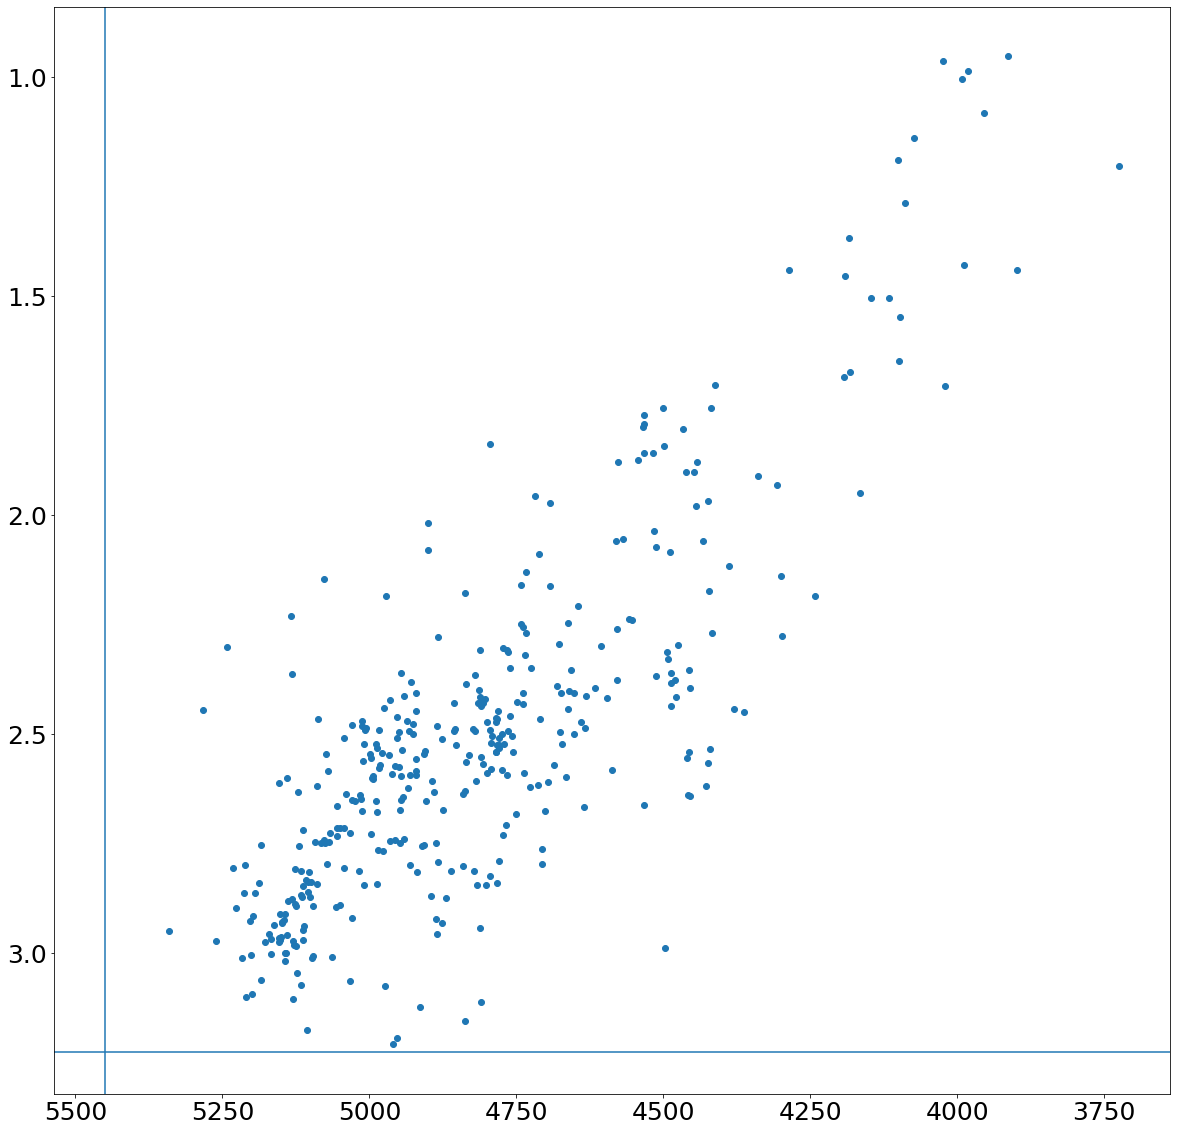

In [68]:
plt.figure(figsize=[20,20])
plt.scatter(ocsdr17['TEFF'],ocsdr17['logg'])
plt.axhline(3.225)
plt.axvline(5450)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [69]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [70]:
# mark rc and agb include in fitting
# run with new salaris -0.08
# maybe a few younger clusters
# with gaia included

In [71]:
def salaris(feh,cnalpha):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
    Inputs:
    ------
        feh: metallcity of a star
        cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
    Output:
    ------
            
    '''
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
    # assign solar value to stars if abundance is bad
    for j in range(len(cnalpha)):
        if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
            cnalpha[j] = 0.0
            
    if np.isfinite(feh)==False:
        feh = 0.0
        
    fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
    salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
    return salfeh

In [105]:
all_sal_feh = np.array([])

for i in range(len(ocsdr17)):
    cnalpha = np.array([ocsdr17['C_FE'][i],ocsdr17['N_FE'][i],ocsdr17['O_FE'][i],ocsdr17['MG_FE'][i],
                        ocsdr17['SI_FE'][i],ocsdr17['S_FE'][i],ocsdr17['CA_FE'][i],ocsdr17['TI_FE'][i]])
    
    all_sal_feh = np.append(all_sal_feh,salaris(ocsdr17['FE_H'][i],cnalpha))
    
max(all_sal_feh)

0.4418346143774105

In [73]:
# p0=[12.0,0.5]
# idx = 10
# cnalpha = np.array([ocsdr17['C_FE'][idx],ocsdr17['N_FE'][idx],ocsdr17['O_FE'][idx],ocsdr17['MG_FE'][idx],
#                     ocsdr17['SI_FE'][idx],ocsdr17['S_FE'][idx],ocsdr17['CA_FE'][idx],ocsdr17['TI_FE'][idx]])

# CalcAge = AetasStellae(ocsdr17['FE_H'][idx],cnalpha,10000,3.1,massive)

# obs_mags = np.array([ocsdr17['J'][idx],ocsdr17['H'][idx],ocsdr17['K'][idx]],dtype=float).T.ravel()
# # obs_mags_err = 

# popt,pcov = curve_fit(CalcAge.Teff2AppMags,ocsdr17['TEFF'][idx],obs_mags,p0=p0,bounds=((0.,0.),(14.,2.)),
#                       method='trf',sigma=np.array([ocsdr17['J_ERR'][idx],ocsdr17['H_ERR'][idx],
#                                                    ocsdr17['K_ERR'][idx]],dtype=float).T.ravel(),
#                       absolute_sigma=True)

# print('Initial',p0)
# print('Age; Ak',popt)
# print(pcov)
# print(np.sqrt(pcov[0][0]))

In [74]:
from scipy.stats import binned_statistic

(-3.0, 0.33556583523750305)

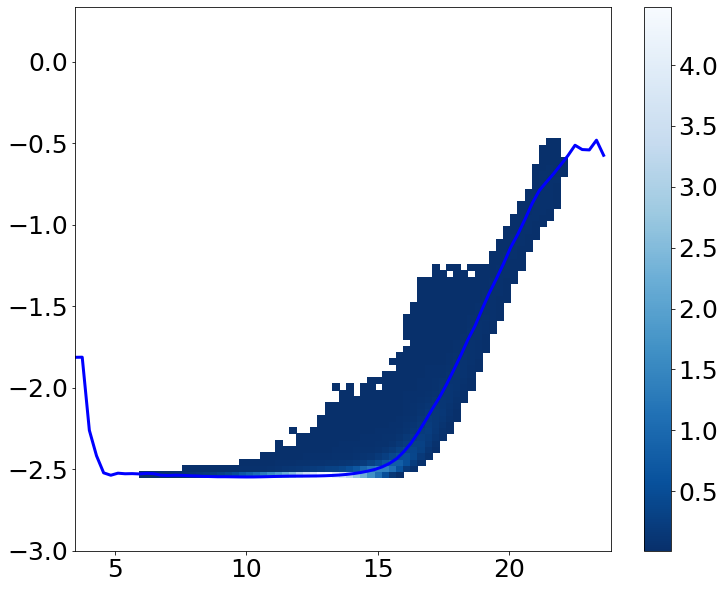

In [75]:
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0028**2)

binnum = 75
bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

plt.figure(figsize=[12,10])
plt.hist2d(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),bins=binnum,density=True,cmin=0.01,
           cmap='Blues_r')
plt.colorbar()

plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue')
plt.ylim(bottom=-3.0)

(-3.0, 0.4064217805862427)

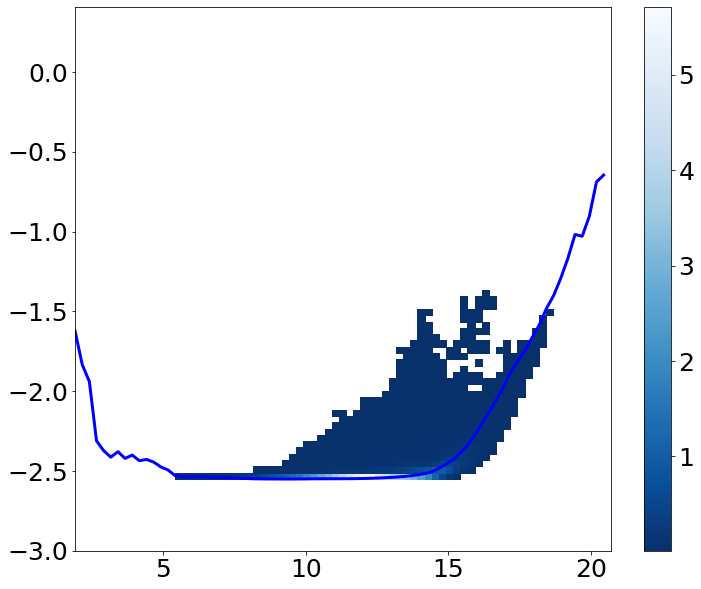

In [76]:
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0028**2)

binnum = 75
rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

plt.figure(figsize=[12,10])
plt.hist2d(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),bins=binnum,density=True,cmin=0.01,
           cmap='Blues_r')
plt.colorbar()

plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='blue')
plt.ylim(bottom=-3.0)

Text(0, 0.5, 'Log(Error)')

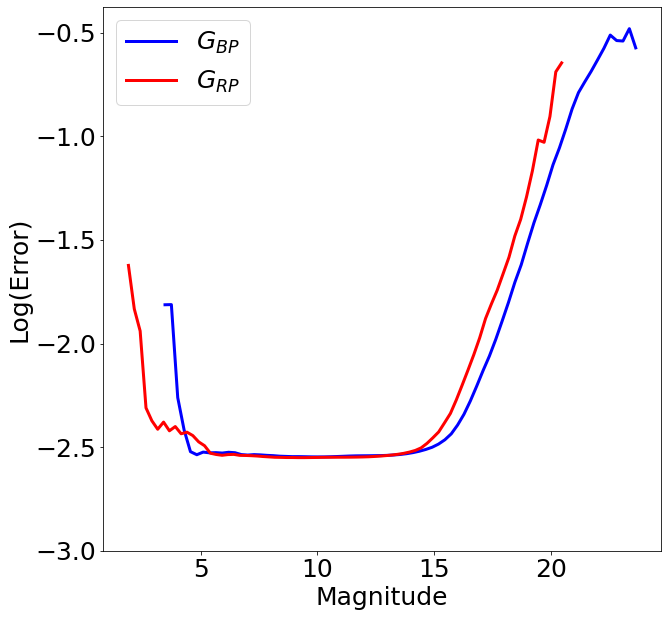

In [77]:
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')

In [78]:
bperrfunc = InterpolatedUnivariateSpline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = InterpolatedUnivariateSpline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(ocsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(ocsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

In [119]:
p0=[12.0,0.5]
idx = 10
cnalpha = np.array([ocsdr17['C_FE'][idx],ocsdr17['N_FE'][idx],ocsdr17['O_FE'][idx],ocsdr17['MG_FE'][idx],
                    ocsdr17['SI_FE'][idx],ocsdr17['S_FE'][idx],ocsdr17['CA_FE'][idx],ocsdr17['TI_FE'][idx]])

CalcAge = AetasStellae([idx],cnalpha,ocs_dist[idx],3.1,massive)

obs_mags = np.array([ocsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][idx],ocsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][idx],
                     ocsdr17['J'][idx],ocsdr17['H'][idx],ocsdr17['K'][idx]],dtype=float).T.ravel()
obs_mags_err = np.array([bperr[idx],rperr[idx],ocsdr17['J'][idx],ocsdr17['H'][idx],
                         ocsdr17['K'][idx]],dtype=float).T.ravel()

popt,pcov = curve_fit(CalcAge.Teff2AppMags,ocsdr17['TEFF'][idx],obs_mags,p0=p0,bounds=((0.,0.),(14.,2.)),
                      method='trf',sigma=obs_mags_err,absolute_sigma=True)

print('Initial',p0)
print('Age; Ak',popt)
print(pcov)
print(np.sqrt(pcov[0][0]))
print(np.sqrt(pcov[1][1]))

Initial [12.0, 0.5]
Age; Ak [1.83896719e+00 1.53323400e-24]
[[ 2.67484991e-04 -1.97910273e-05]
 [-1.97910273e-05  1.53916944e-06]]
0.01635496838549627
0.0012406326791415186


In [120]:
### Run All Stars
guess_ages = np.arange(0,14)
guess_aks = np.array([0,0.5,1.0])

best_ages = 999999.0*np.ones(len(ocsdr17))#np.ones((len(ocs),len(guess_ages),len(guess_aks)))
best_aks = 999999.0*np.ones(len(ocsdr17))#np.ones((len(ocs),len(guess_ages),len(guess_aks)))
best_ages_err = 999999.0*np.ones(len(ocsdr17))#np.ones((len(ocs),len(guess_ages),len(guess_aks)))
best_aks_err = 999999.0*np.ones(len(ocsdr17))#np.ones((len(ocs),len(guess_ages),len(guess_aks)))
best_chis = 999999.0*np.ones(len(ocsdr17))#np.ones((len(ocs),len(guess_ages),len(guess_aks)))


for i in tqdm_notebook(range(len(ocsdr17))):
    curve_ages = []
    curve_aks = []
    curve_ages_err = []
    curve_aks_err = []
    curve_chi = []
    
    cnalpha = np.array([ocsdr17['C_FE'][i],ocsdr17['N_FE'][i],ocsdr17['O_FE'][i],ocsdr17['MG_FE'][i],
                        ocsdr17['SI_FE'][i],ocsdr17['S_FE'][i],ocsdr17['CA_FE'][i],ocsdr17['TI_FE'][i]])
    
    CalcAge = AetasStellae(ocsdr17['FE_H'][i],cnalpha,ocs_dist[i],3.1,massive)
    for j in range(len(guess_ages)):
        for k in range(len(guess_aks)):
            try:
                obs_mags = np.array([ocsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                                     ocsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                                     ocsdr17['J'][i],ocsdr17['H'][i],
                                     ocsdr17['K'][i]],dtype=float).T.ravel()
                
                obs_sigs = np.array([bperr[i],rperr[i],ocsdr17['J'][i],ocsdr17['H'][i],ocsdr17['K'][i]],
                                    dtype=float).T.ravel()
                
                popt,pcov = curve_fit(CalcAge.Teff2AppMags,ocsdr17['TEFF'][i],
                                   obs_mags,p0=[guess_ages[j],guess_aks[k]],bounds=((0.,0.),(14.,2.)),
                                   method='trf',sigma=obs_sigs,absolute_sigma=True,maxfev=5000)
            
                curve_ages.append(popt[0])
                curve_aks.append(popt[1])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_aks_err.append(np.sqrt(pcov[1][1]))
                curve_mags = np.asarray(CalcAge.Teff2AppMags(ocsdr17['TEFF'][i],popt[0],popt[1]))
                curve_chi.append(sum((curve_mags-obs_mags)**2/obs_sigs**2))
            
            except:
#                 print([i,j,k])
                curve_ages.append(999999.0)
                curve_aks.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_aks_err.append(999999.0)
                curve_chi.append(999999.0)
                
    best_idx = np.asarray(curve_chi).argmin()
    best_chis[i] = np.min(curve_chi)
    best_ages[i] = np.asarray(curve_ages)[best_idx]
    best_aks[i] = np.asarray(curve_aks)[best_idx]
    best_ages_err[i] = np.asarray(curve_ages_err)[best_idx]
    best_aks_err[i] = np.asarray(curve_aks_err)[best_idx]

<ipython-input-120-bb58fd7a807c>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ocsdr17))):


(3.501258793919196, 10.0)

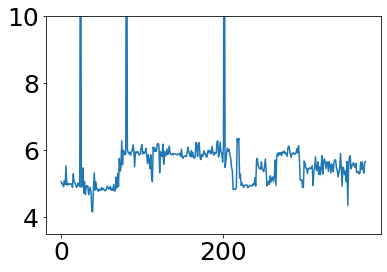

In [121]:
plt.plot(np.log10(best_chis))
plt.ylim(top=10)

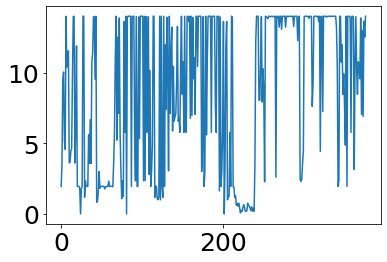

In [122]:
plt.plot(best_ages)

In [123]:
calc_clus_ages = np.array([])
for i in range(len(ocs_clus)):
    clus = np.where((ocmem['CLUSTER']==ocs_clus[i])&(best_ages!=999999.0))
    calc_clus_ages = np.append(calc_clus_ages,np.median(best_ages[clus]))
    
print(calc_clus_ages)
print(ocs_ages)
print(calc_clus_ages-ocs_ages)

[13.97494155 14.          9.17487165  0.45851954  5.5460963  13.97494181
 13.62495255  0.19777655  2.34984921  1.91232538  6.58745973 10.44997276
  1.94984458  0.5118868   5.63745949 14.         11.64993231]
[8.51138038e-03 4.36515832e-02 1.28824955e-02 1.20226443e+01
 5.01187234e+00 1.12201845e-02 5.12861384e-03 1.77827941e-01
 4.25598413e-01 6.30957344e-01 7.14496326e-02 1.35207256e-01
 5.05824662e-01 1.58489319e+00 4.28548520e+00 4.67735141e-03
 1.28824955e-02]
[ 13.96643017  13.95634842   9.16198916 -11.56412481   0.53422397
  13.96372163  13.61982394   0.0199486    1.9242508    1.28136803
   6.5160101   10.3147655    1.44401992  -1.07300639   1.35197429
  13.99532265  11.63704981]


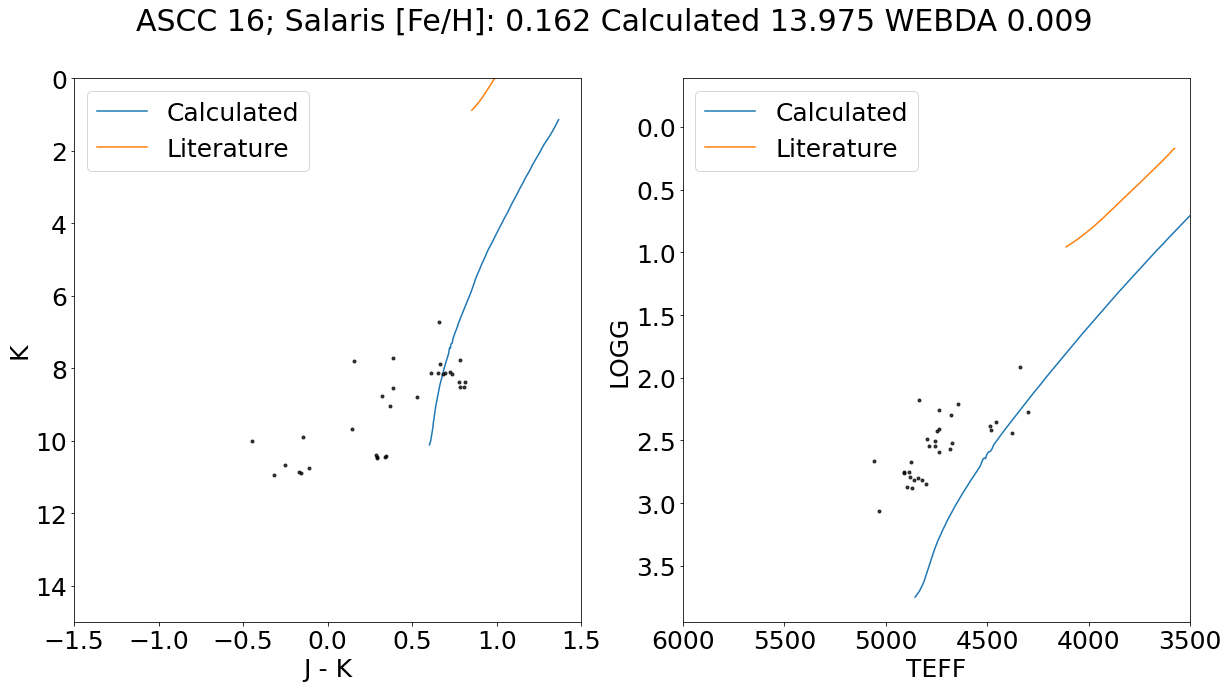

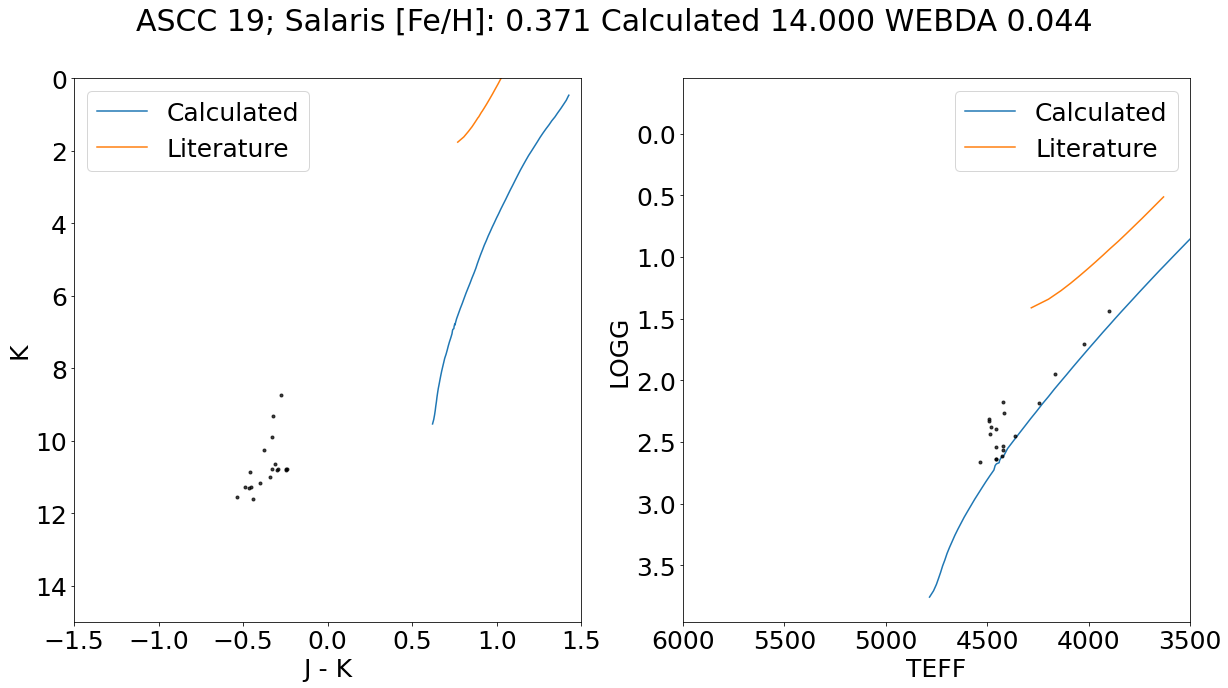

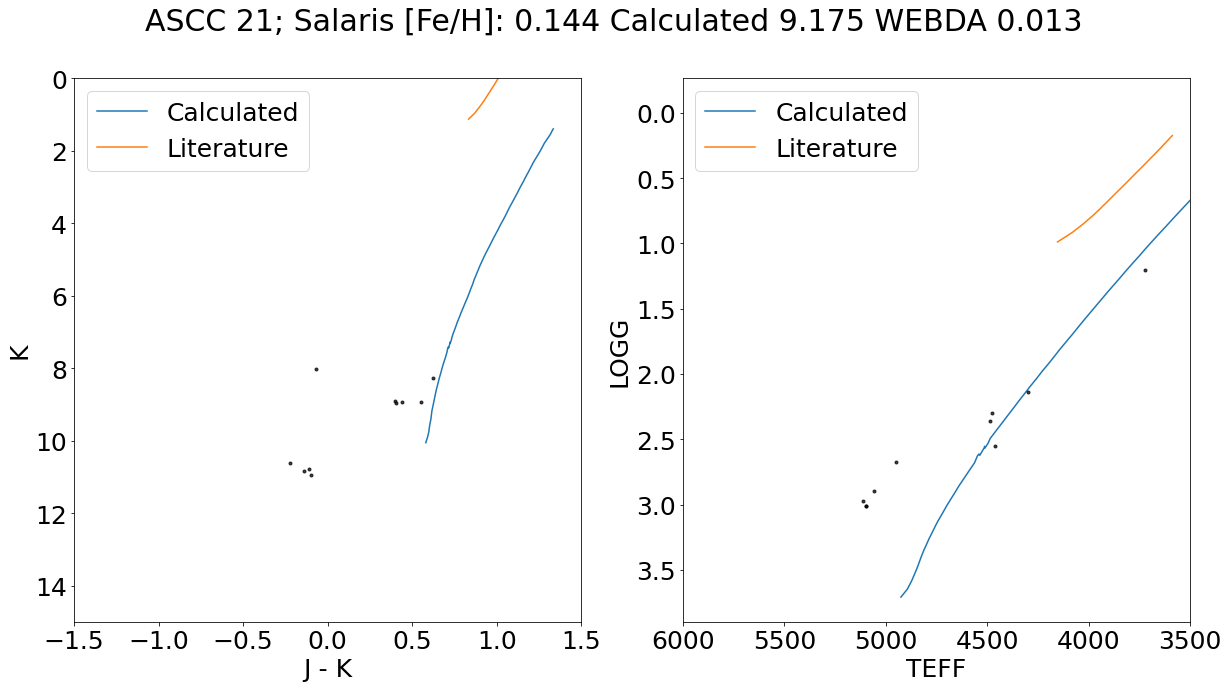

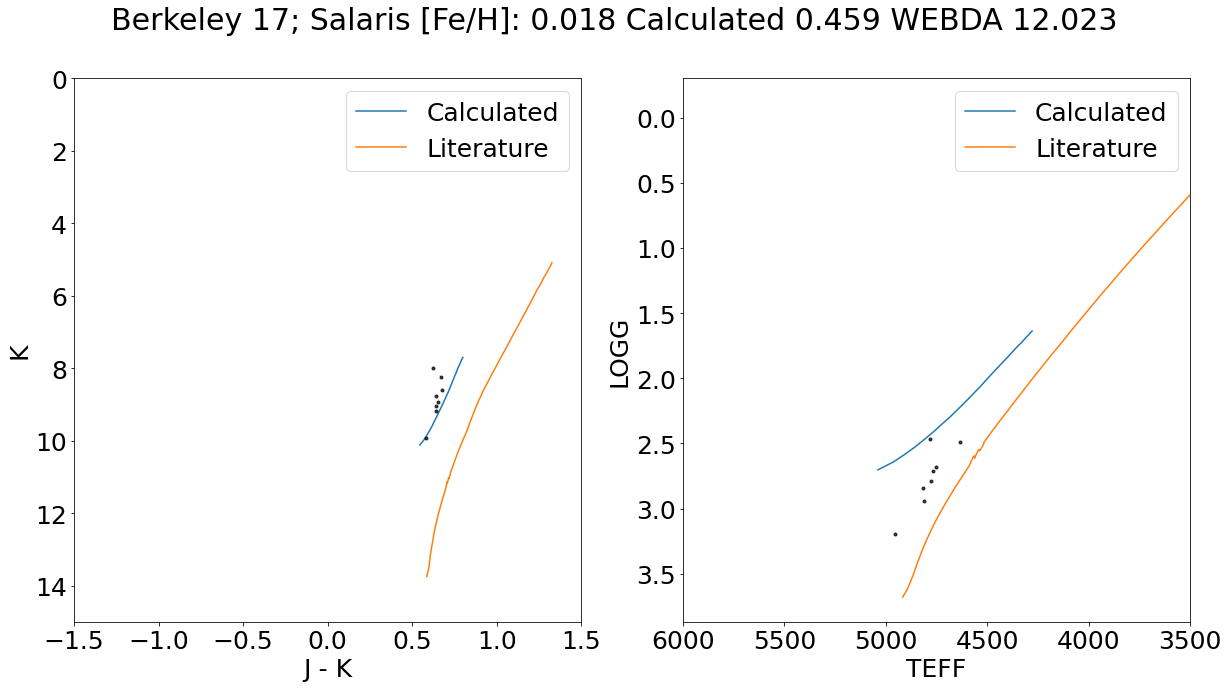

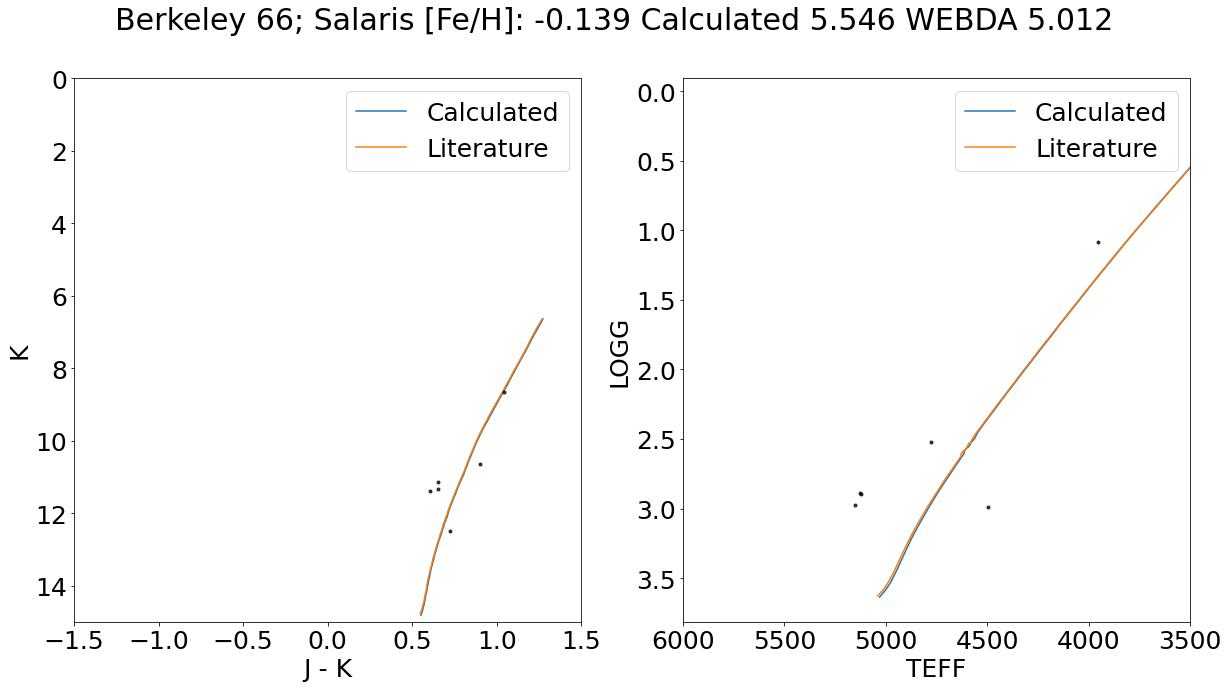

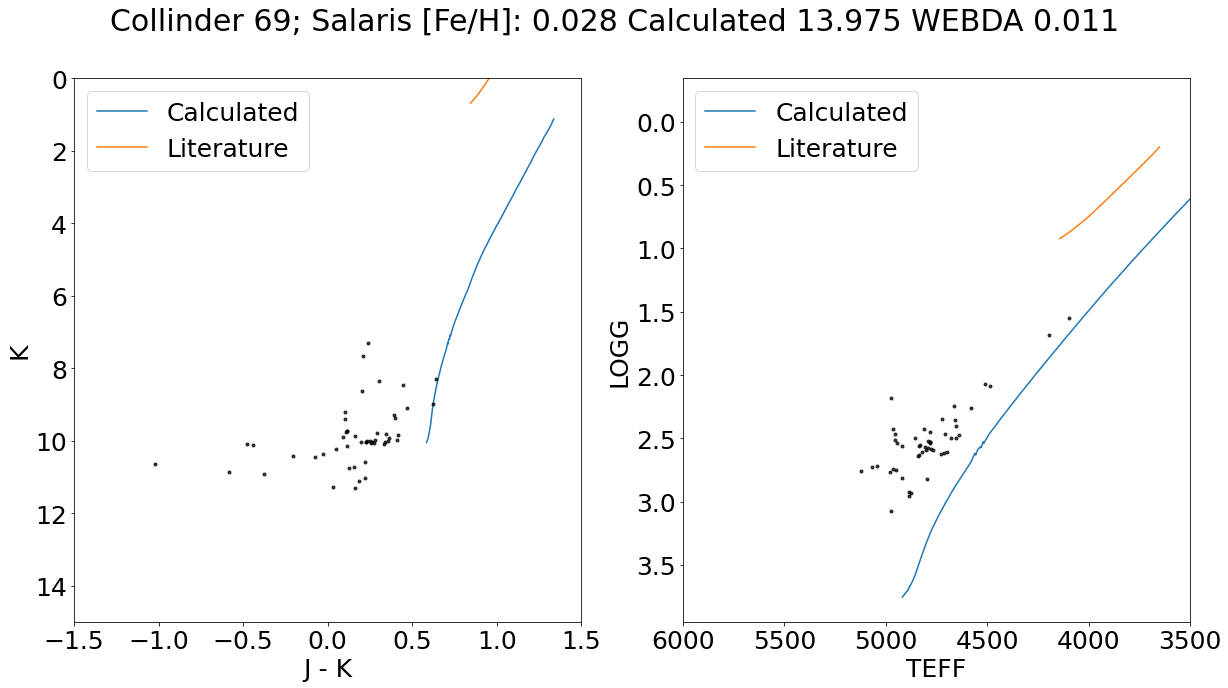

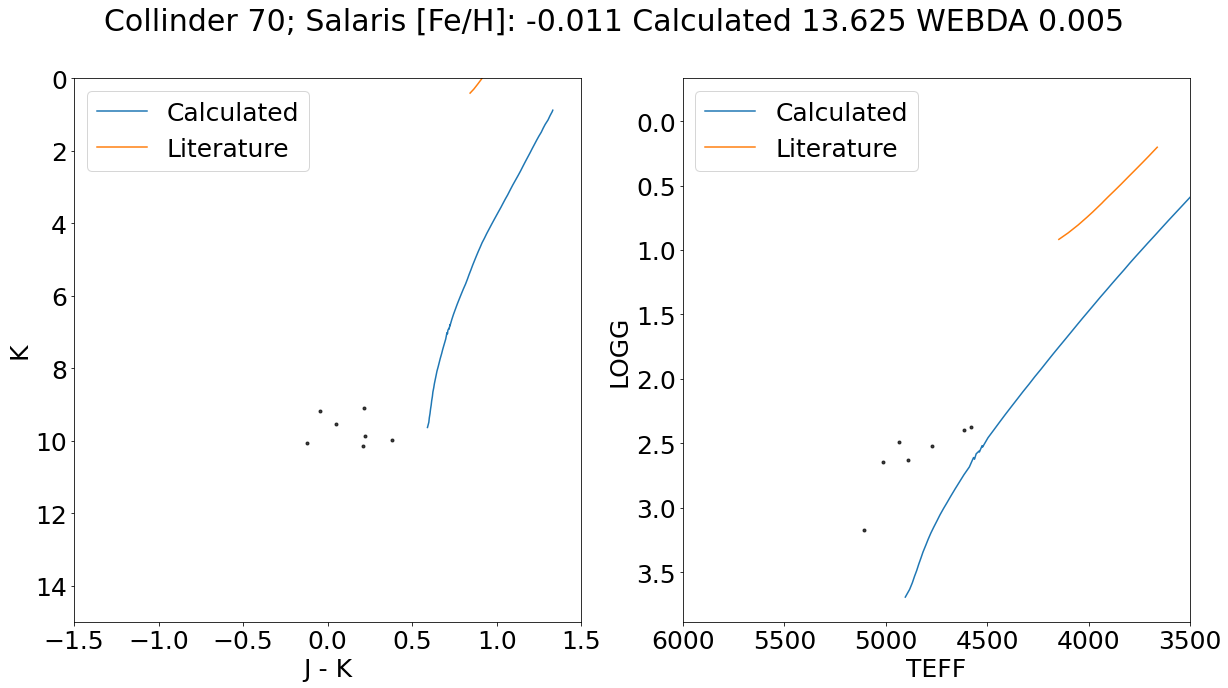

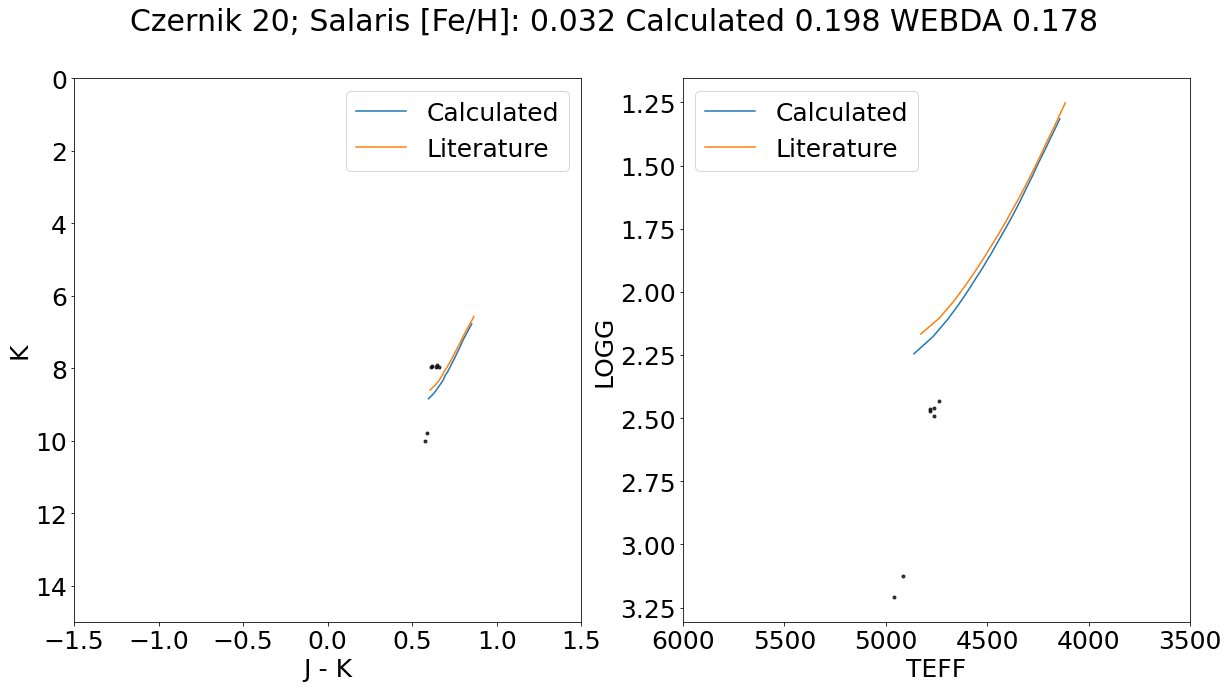

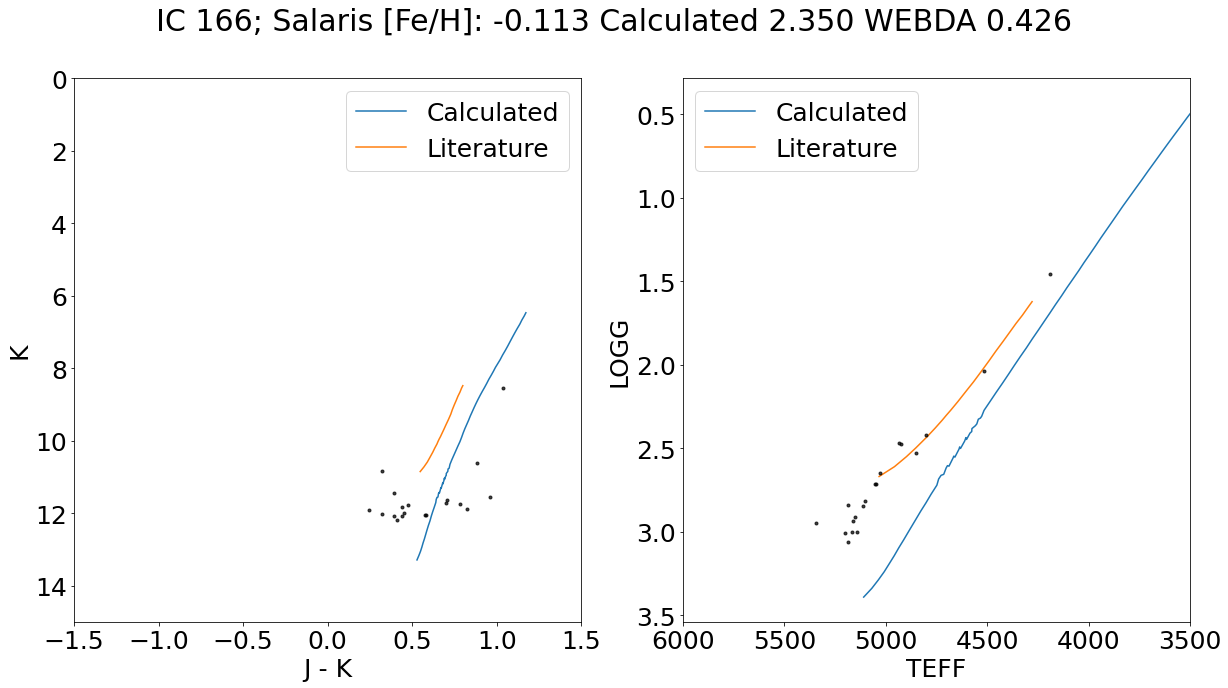

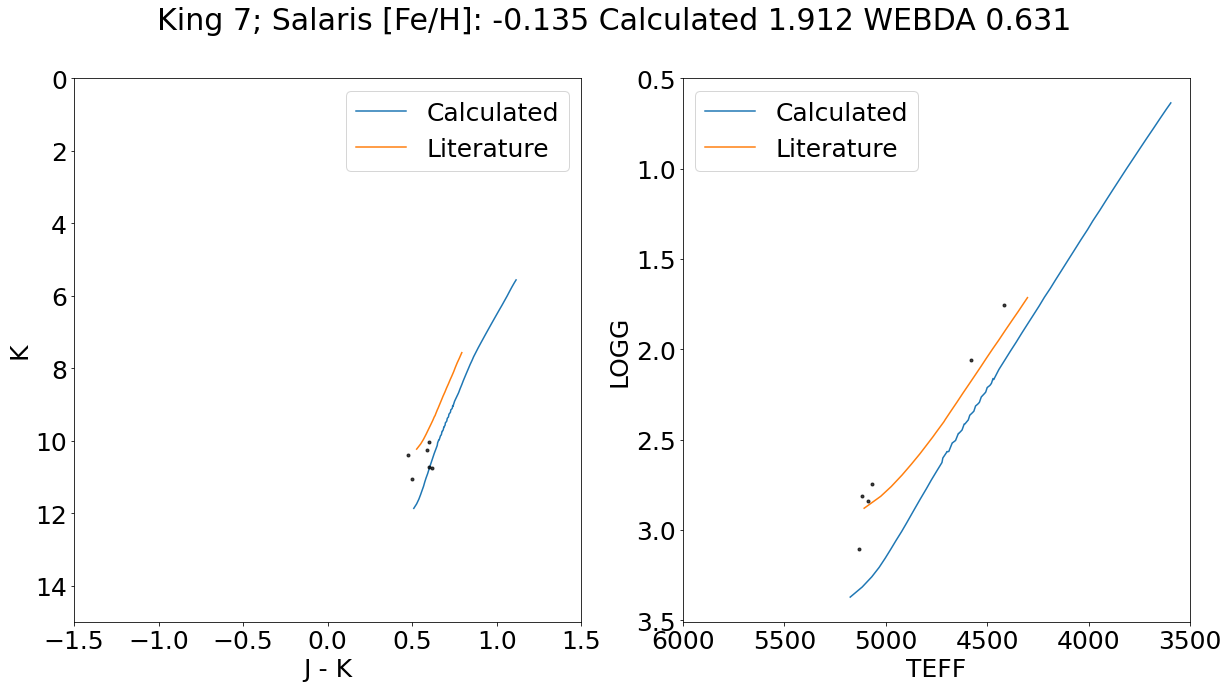

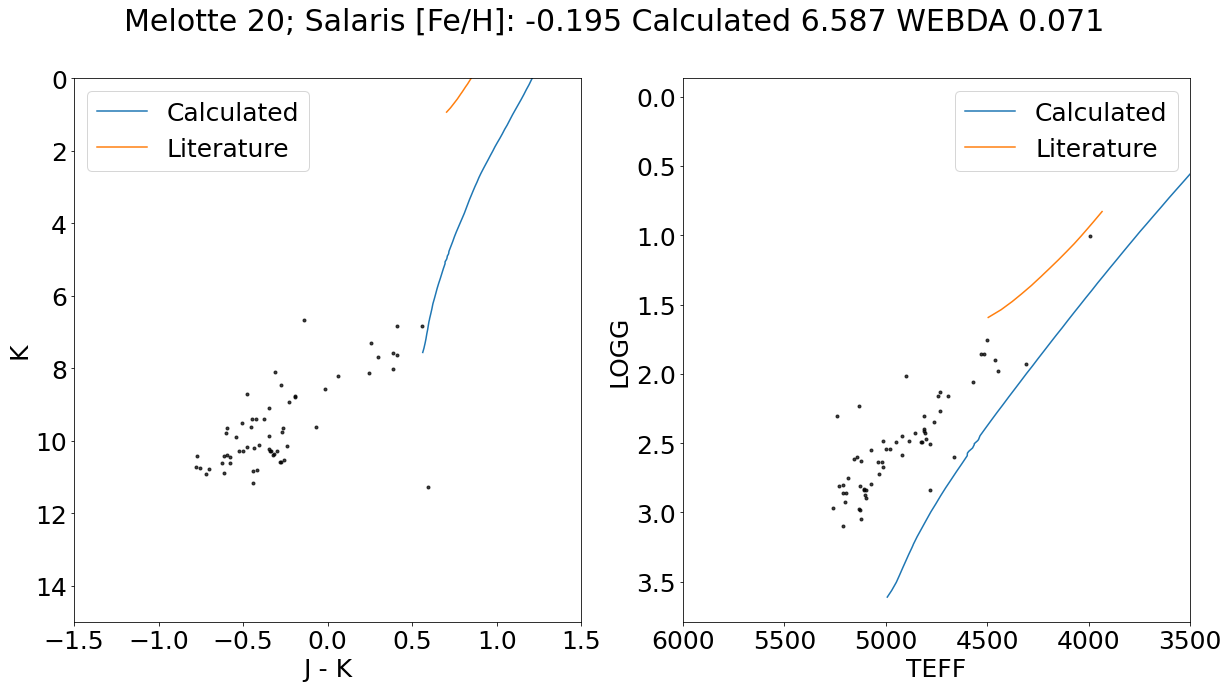

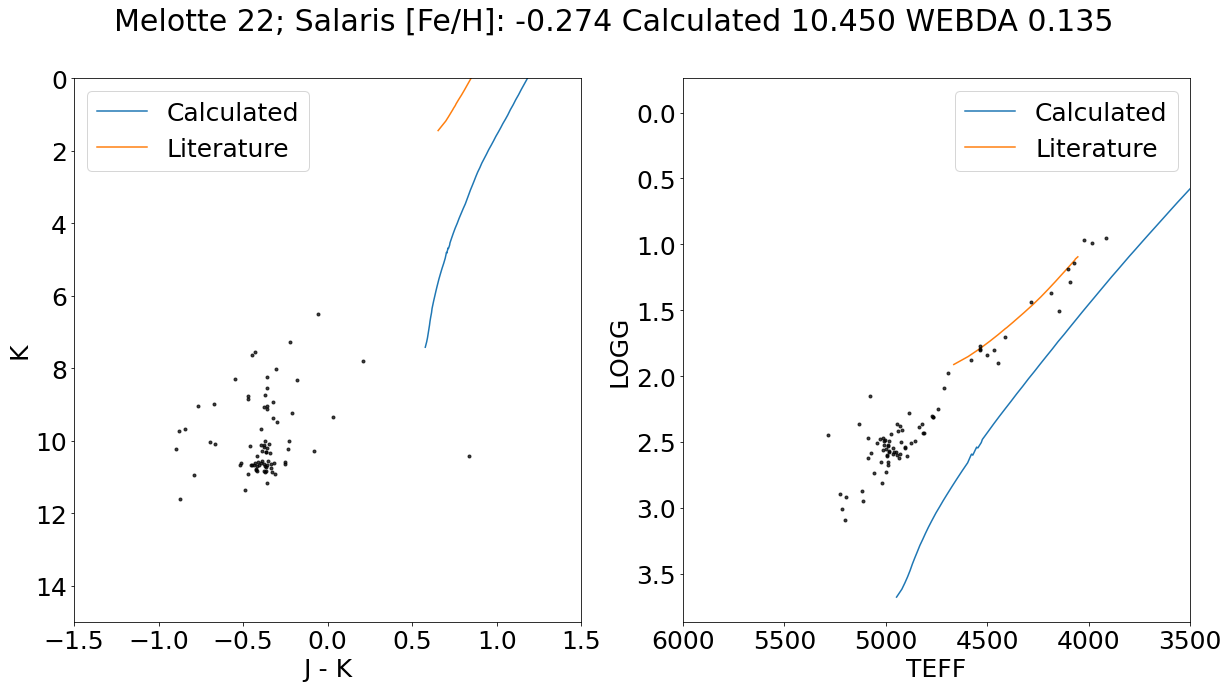

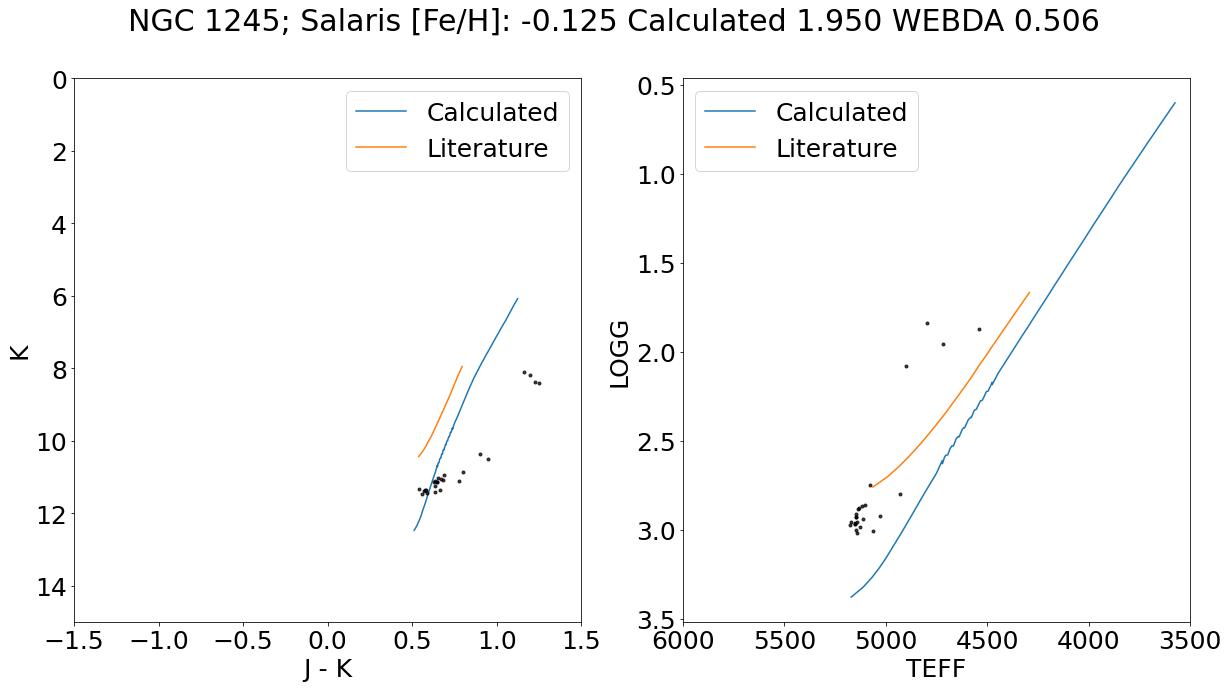

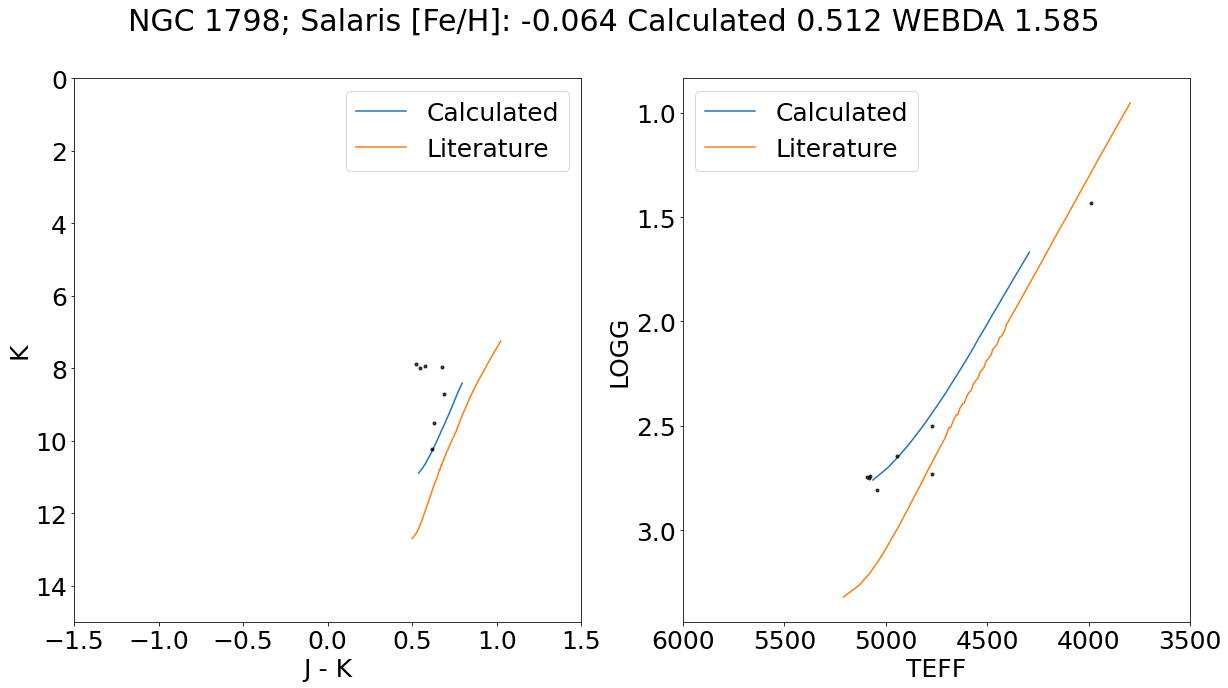

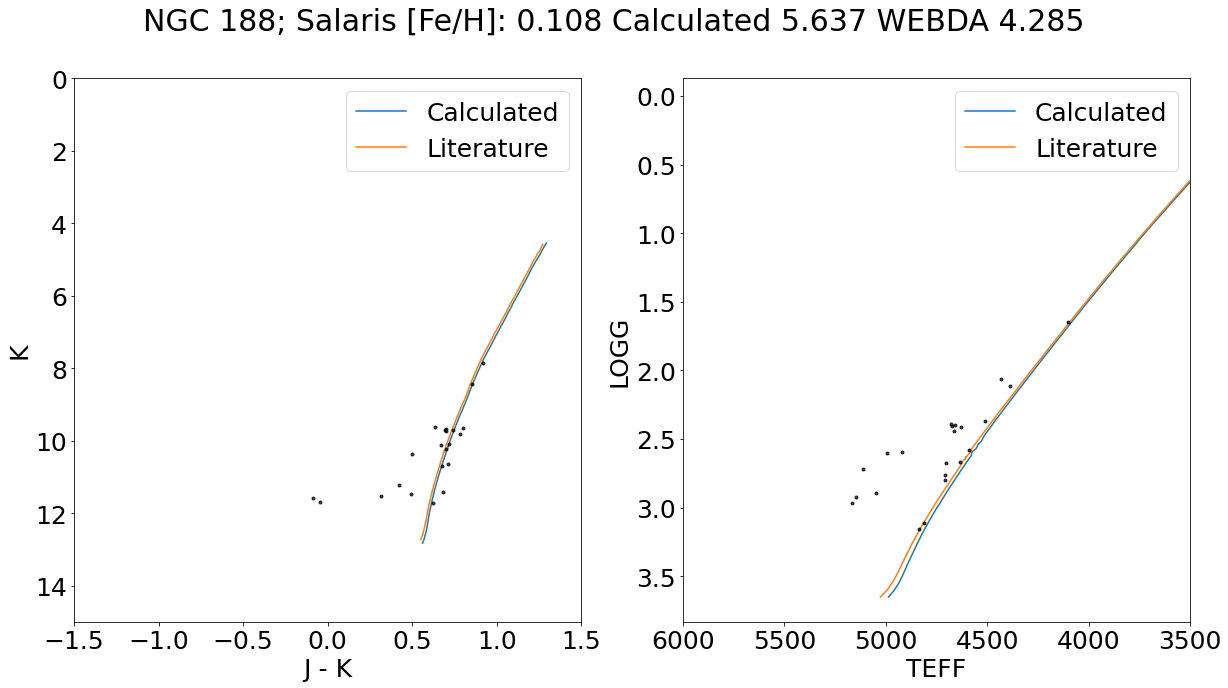

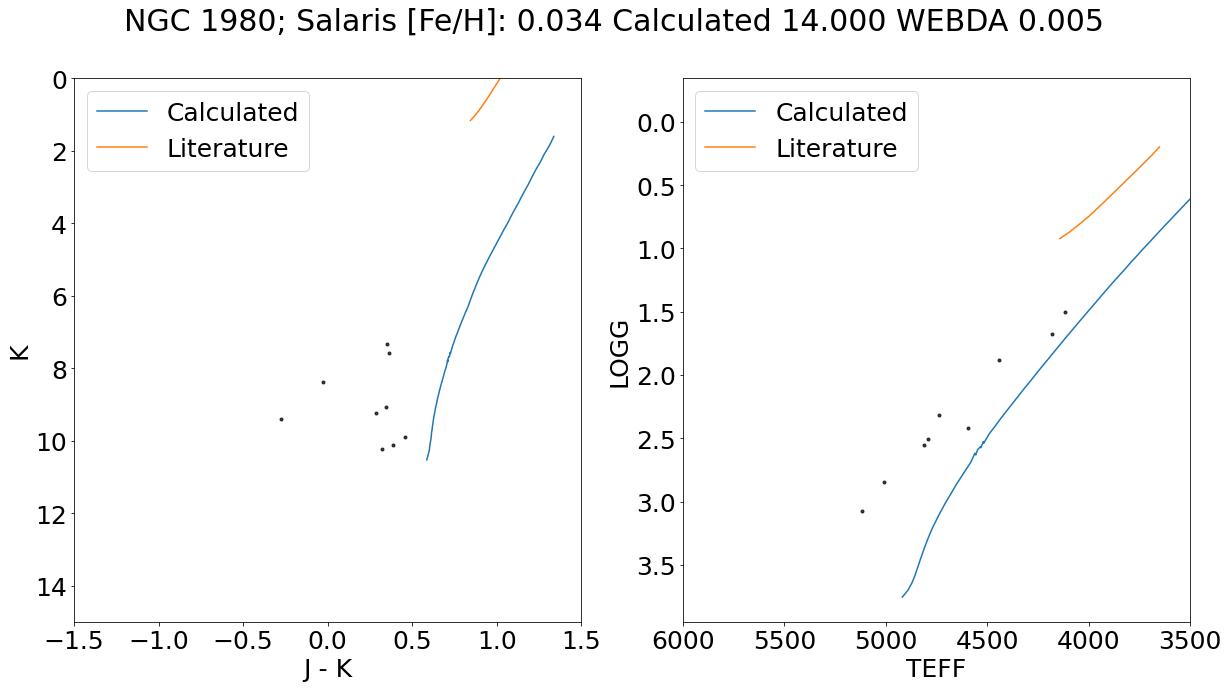

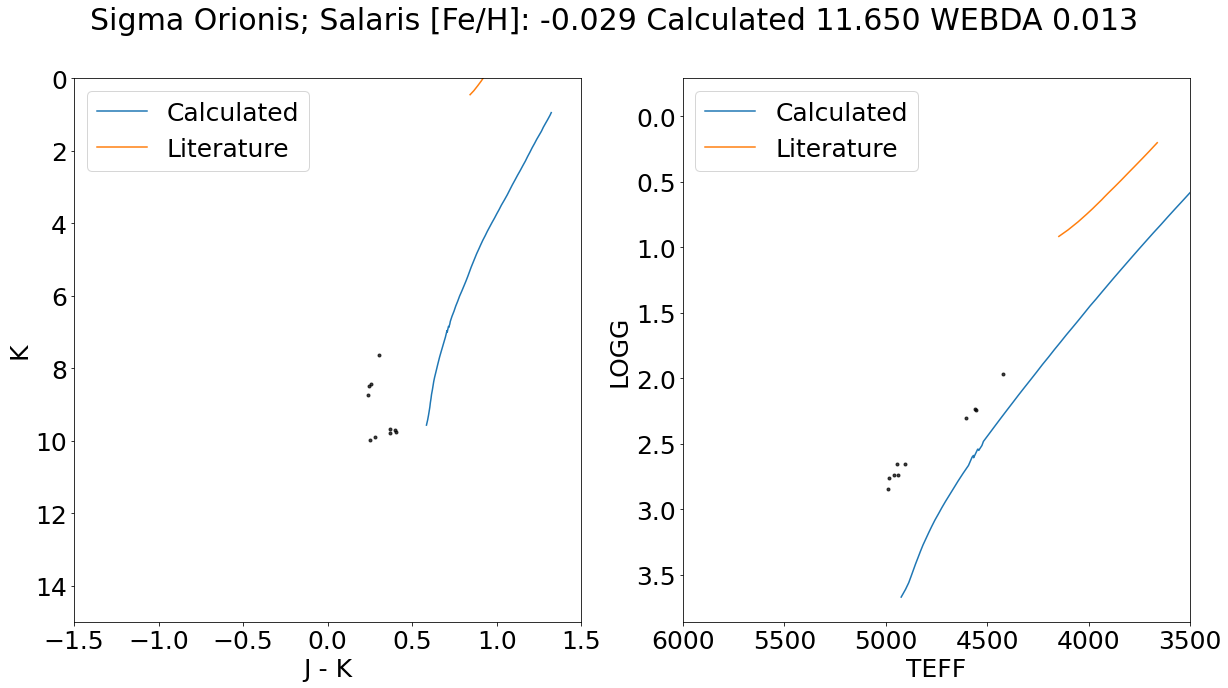

In [133]:
for i in range(len(ocs_clus)):
    clus = np.where((ocmem['CLUSTER']==ocs_clus[i])&(best_aks!=999999.0))
    isopick = np.where((massive['MH']==closest(massive['MH'],np.median(all_sal_feh[clus])))&
                       (massive['logAge']==closest(massive['logAge'],np.log10(calc_clus_ages[i]*10**9))))
    
    calc_sort = np.argsort(massive['logTe'][isopick])
    
    isopick2 = np.where((massive['MH']==closest(massive['MH'],np.median(all_sal_feh[clus])))&
                       (massive['logAge']==closest(massive['logAge'],np.log10(ocs_ages[i]*10**9))))
    
    lite_sort = np.argsort(massive['logTe'][isopick2])
    
    fig, ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].plot((massive['Jmag']-massive['Ksmag'])[isopick][calc_sort],
                  massive['Ksmag'][isopick][calc_sort]+5.*np.log10(ocs_clus_dist[i])-5.0,zorder=0,
               label='Calculated')
    ax[0].plot((massive['Jmag']-massive['Ksmag'])[isopick2][lite_sort],
                  massive['Ksmag'][isopick2][lite_sort]+5.*np.log10(ocs_clus_dist[i])-5.0,zorder=0,label='Literature')
    ax[0].legend()
    ax[0].scatter((ocsdr17['J']-ocsdr17['K']-best_aks*ejk_ak)[clus],ocsdr17['K'][clus]-best_aks[clus],c='k',
                  marker='.',zorder=1,alpha=0.75)
    ax[0].set_xlim(-1.5,1.5)
    ax[0].set_ylim(0,15)
    ax[0].invert_yaxis()
    ax[0].set_xlabel(r'J - K')
    ax[0].set_ylabel(r'K')
    
    ax[1].plot(10**massive['logTe'][isopick][calc_sort],massive['logg'][isopick][calc_sort],
                  zorder=0,label='Calculated')
    ax[1].plot(10**massive['logTe'][isopick2][lite_sort],massive['logg'][isopick2][lite_sort],
                  zorder=0,label='Literature')
    ax[1].legend()
    ax[1].scatter(ocsdr17['TEFF'][clus],ocsdr17['LOGG'][clus],c='k',marker='.',zorder=1,alpha=0.75)
    ax[1].set_xlim(3500,6000)
    ax[1].set_xlabel(r'TEFF')
    ax[1].set_ylabel(r'LOGG')
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    
    plt.suptitle(r'{}; Salaris [Fe/H]: {:.3f} Calculated {:.3f} WEBDA {:.3f}'.format(ocs_clus[i],
                                                                                     np.median(all_sal_feh[clus]),
                                                                                     calc_clus_ages[i],
                                                                                     ocs_ages[i]))
    plt.savefig('{}OCCMDHR.pdf'.format(ocs_clus[i]),bbox_inches='tight')
#     plt.title(r'K, J - K; {}; Color as Age'.format(ocs_clus[i]))
    plt.show()

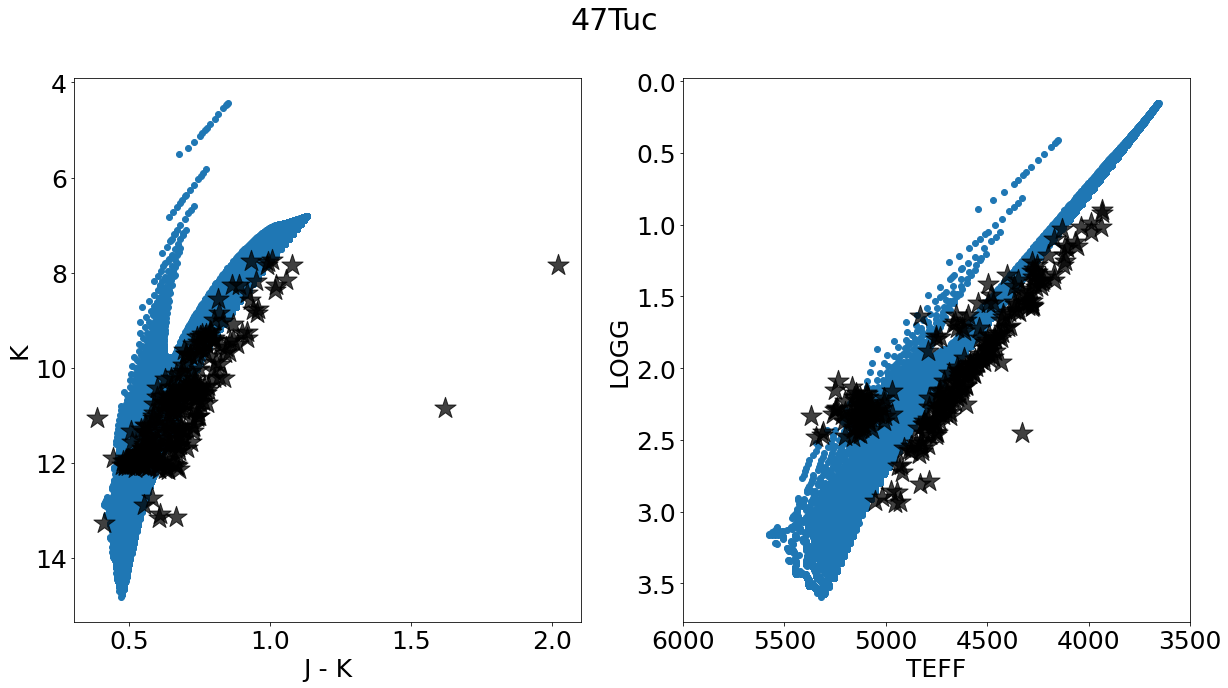

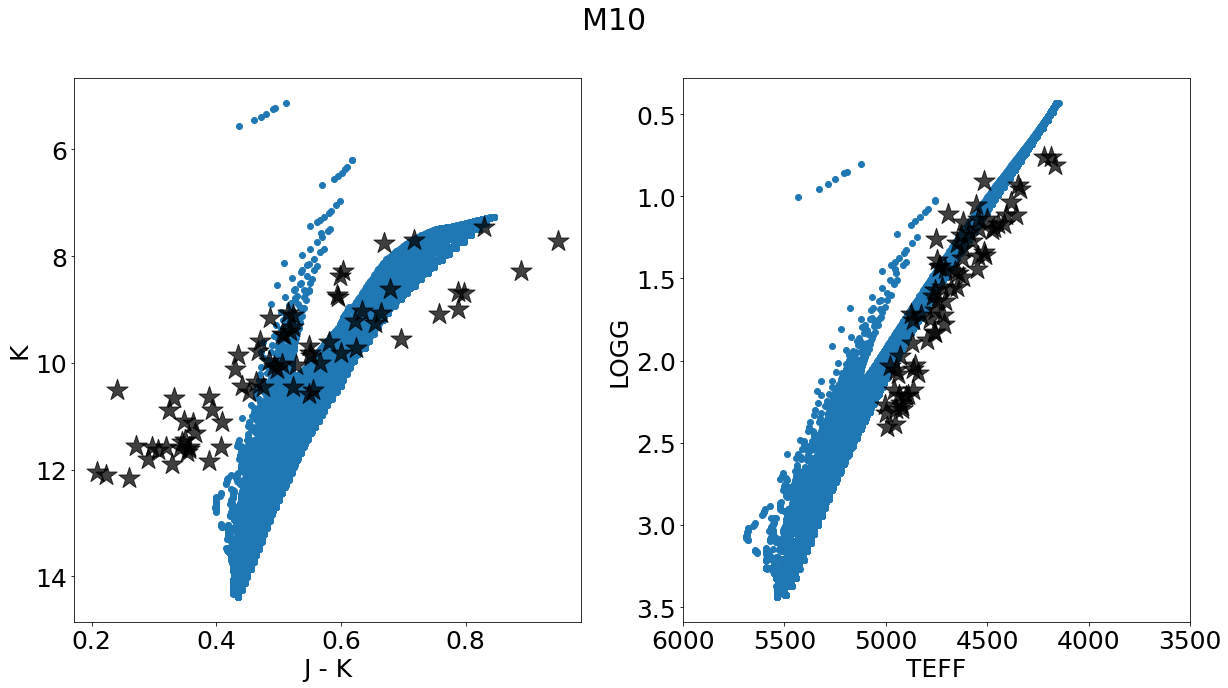

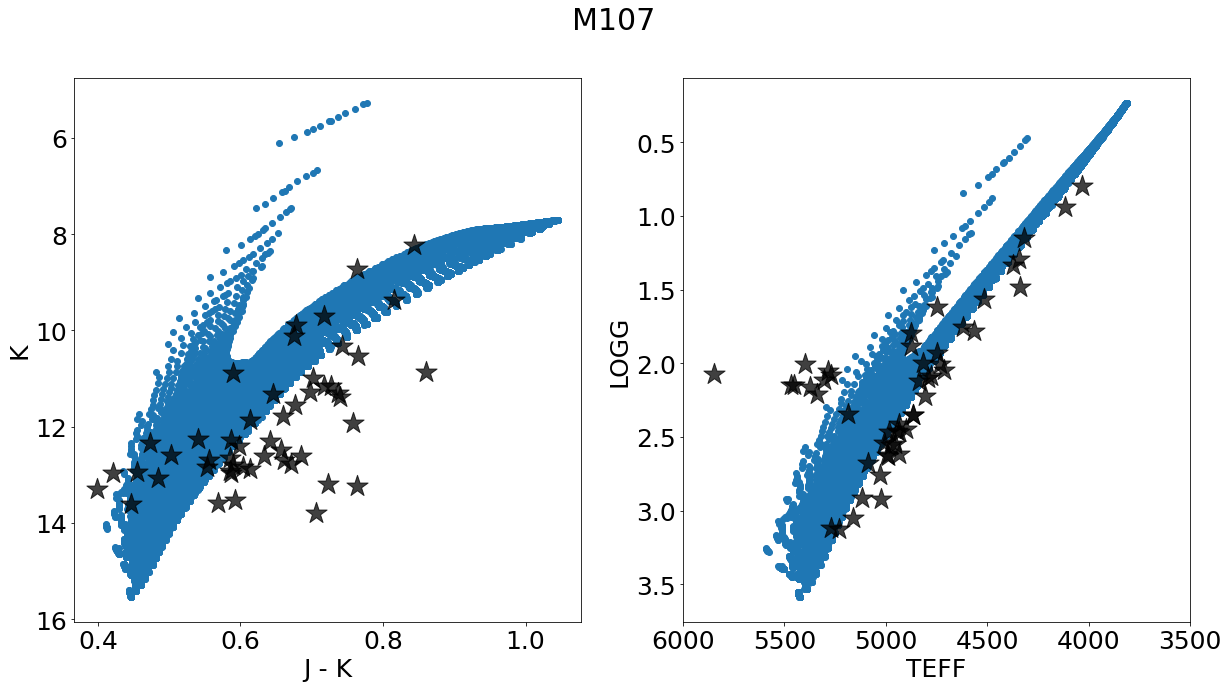

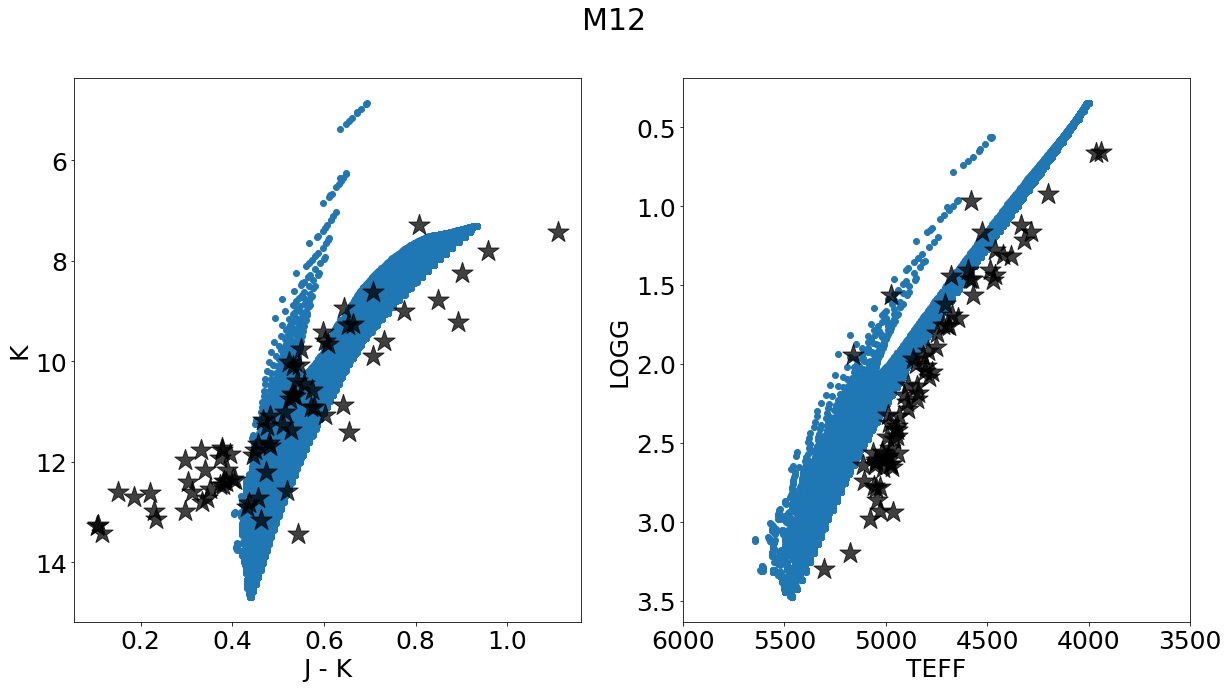

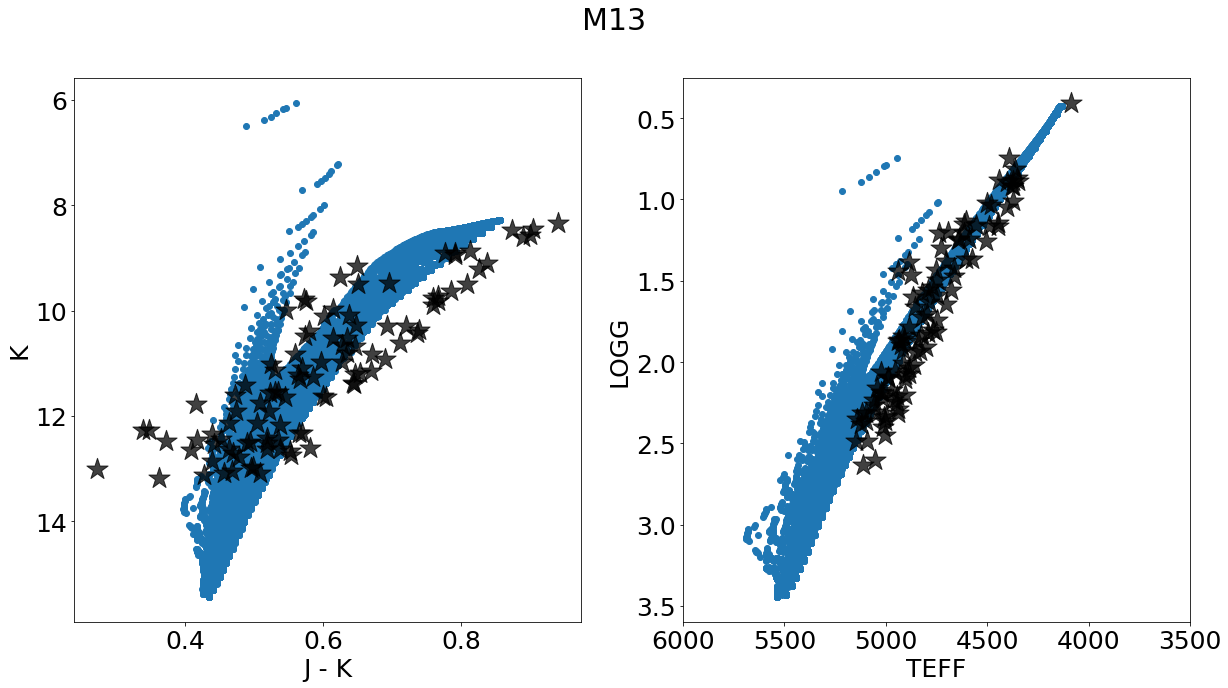

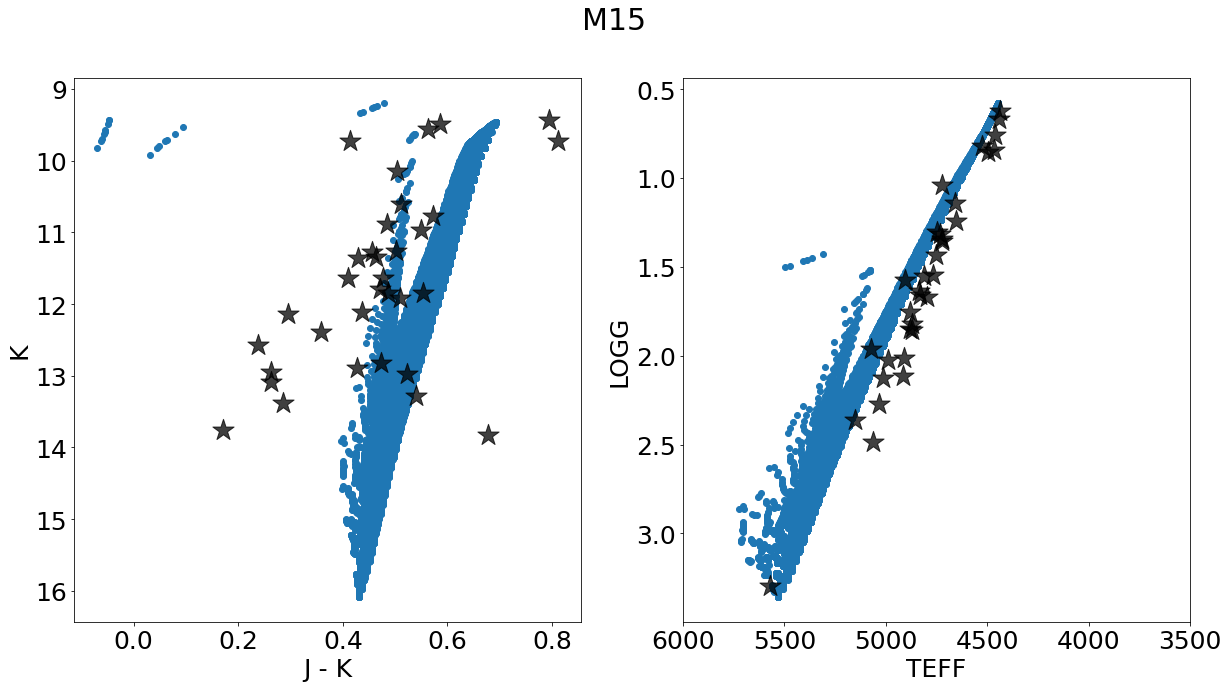

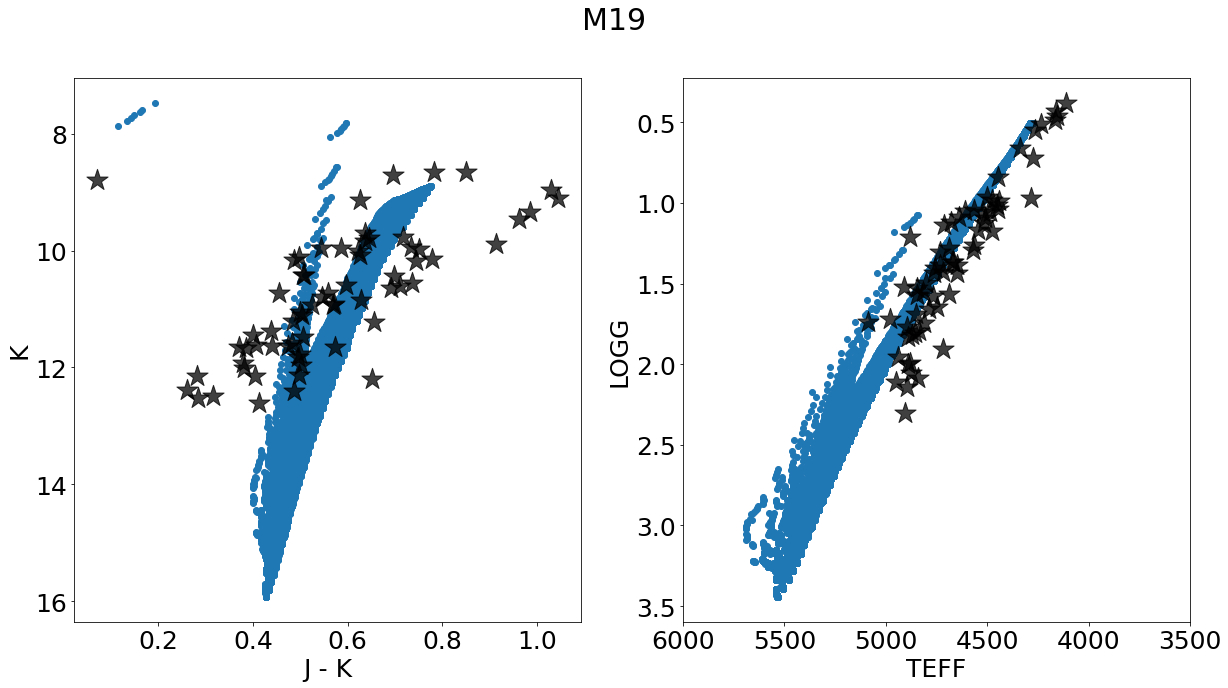

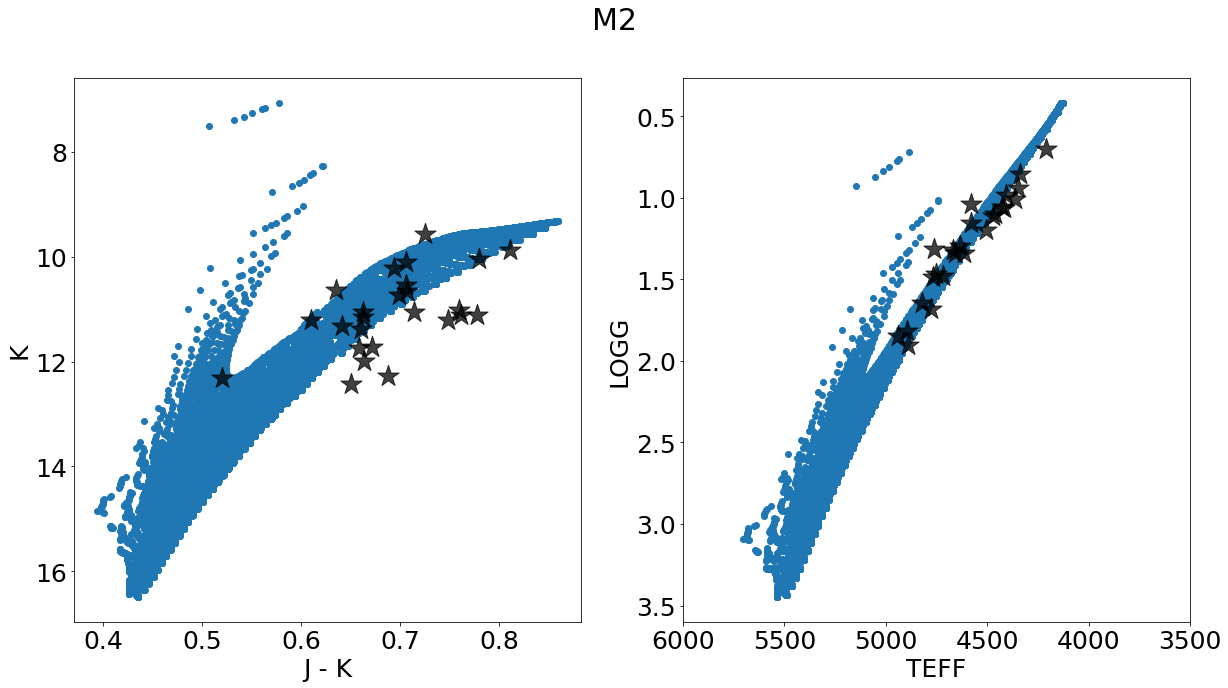

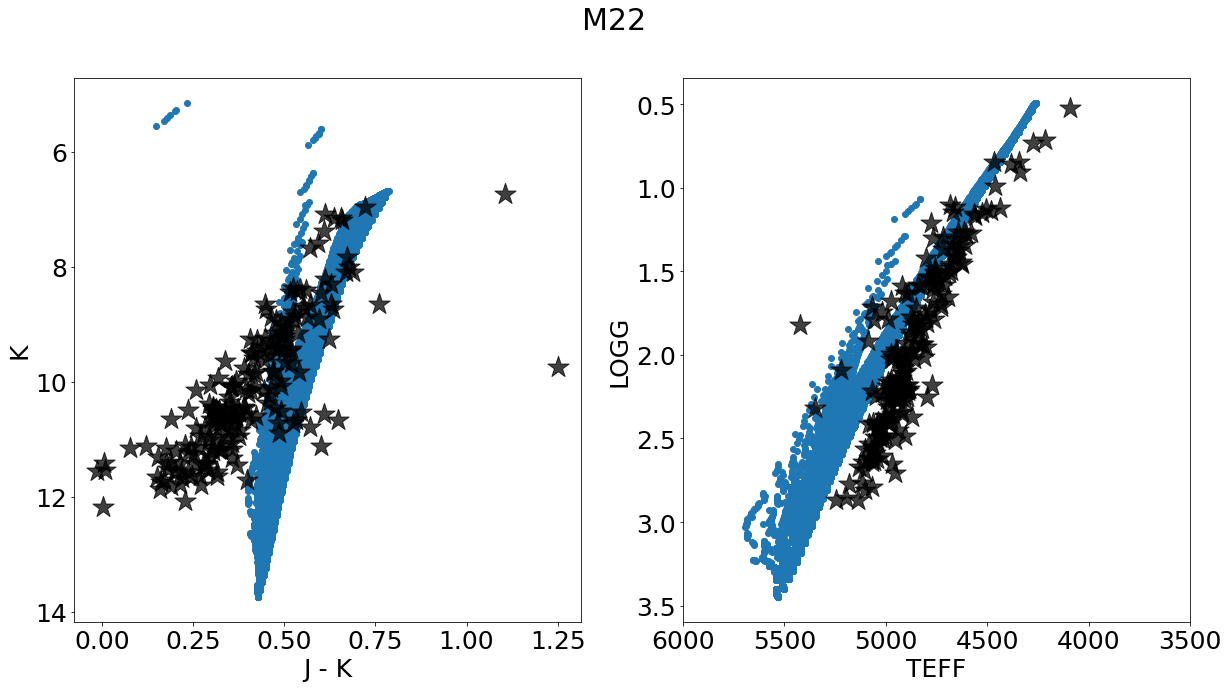

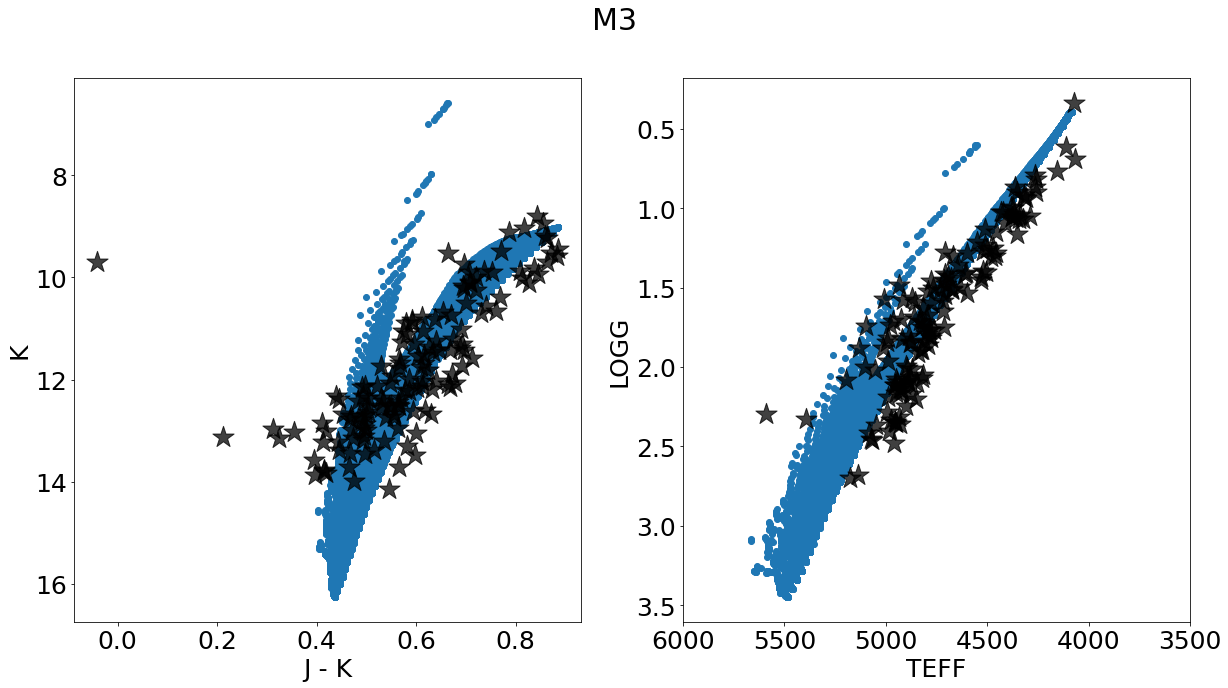

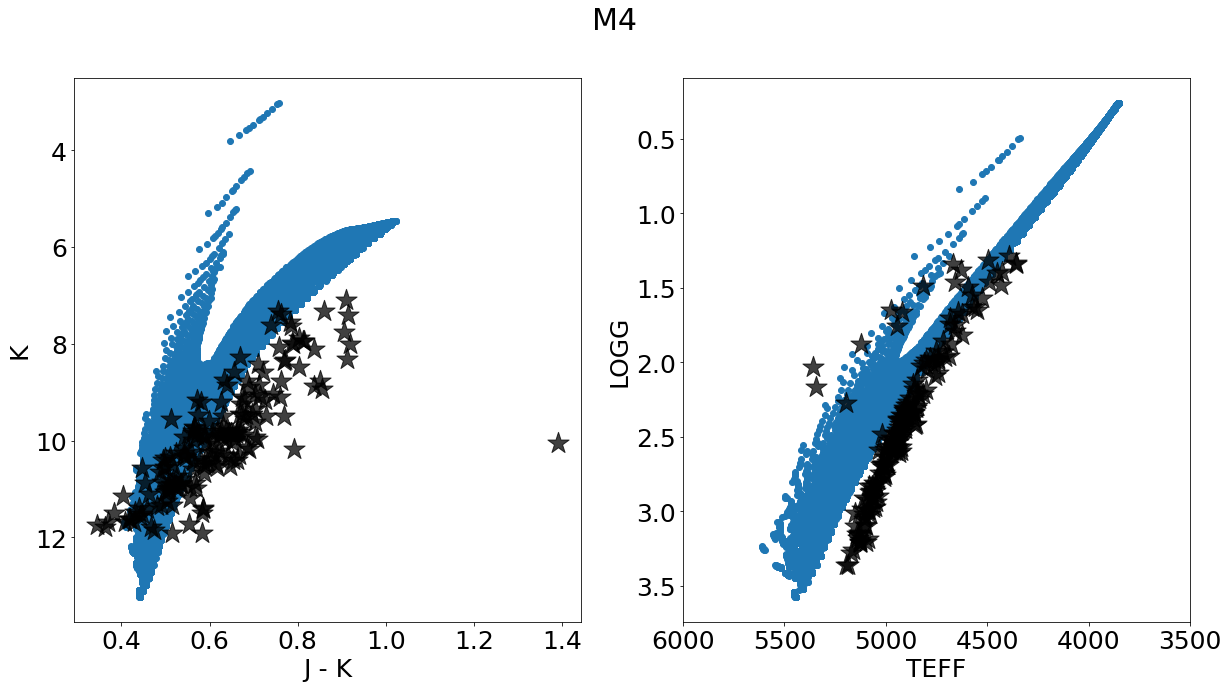

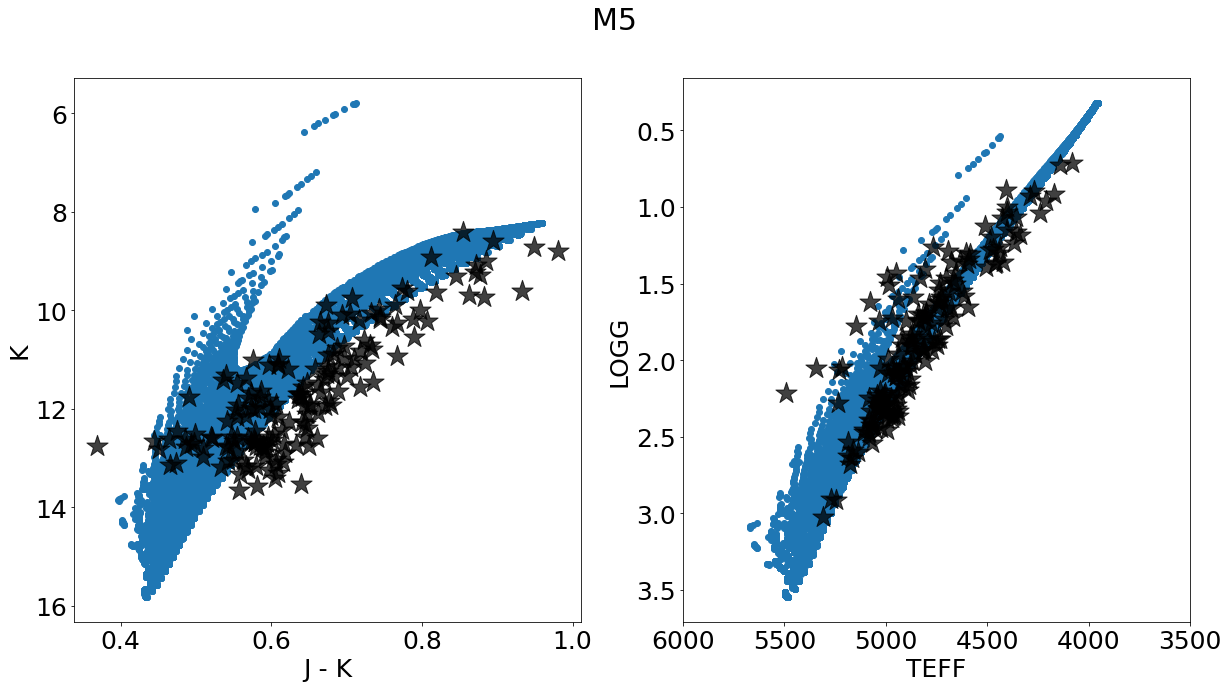

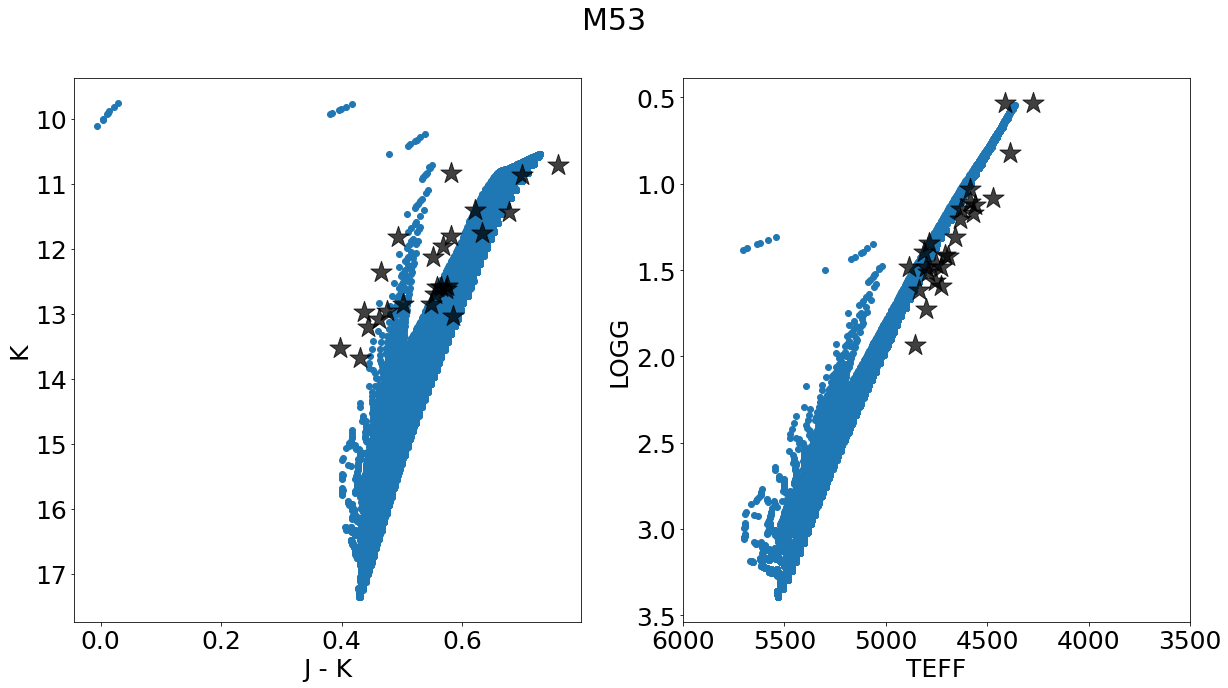

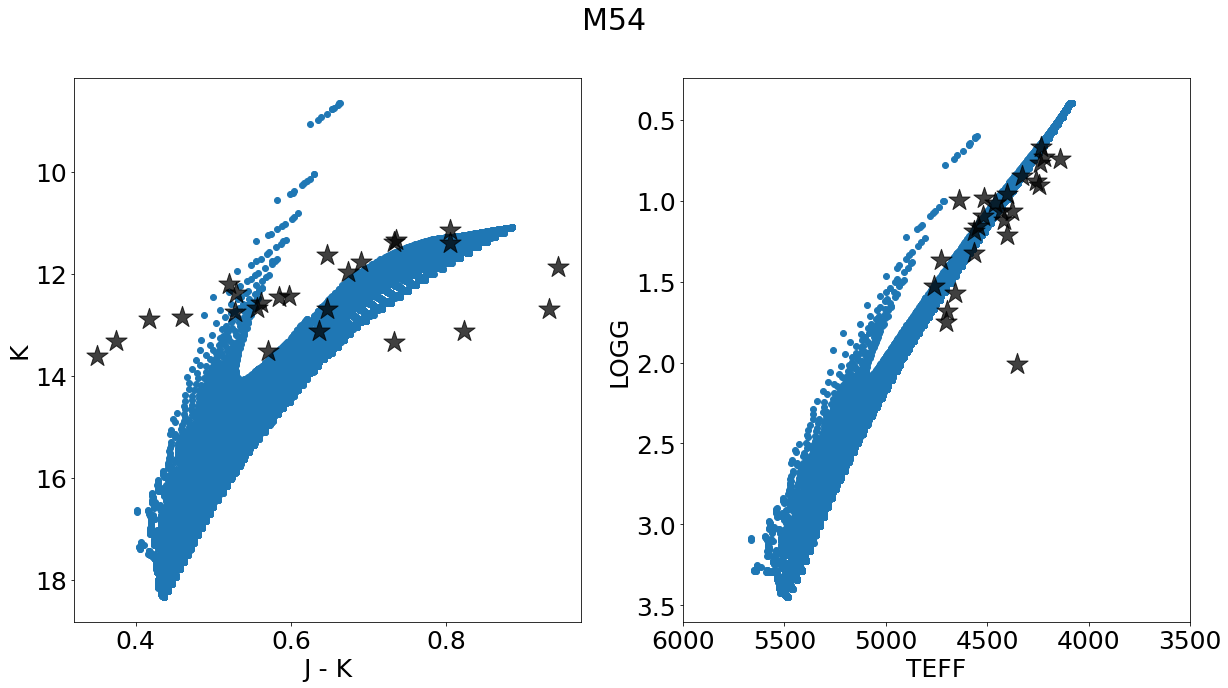

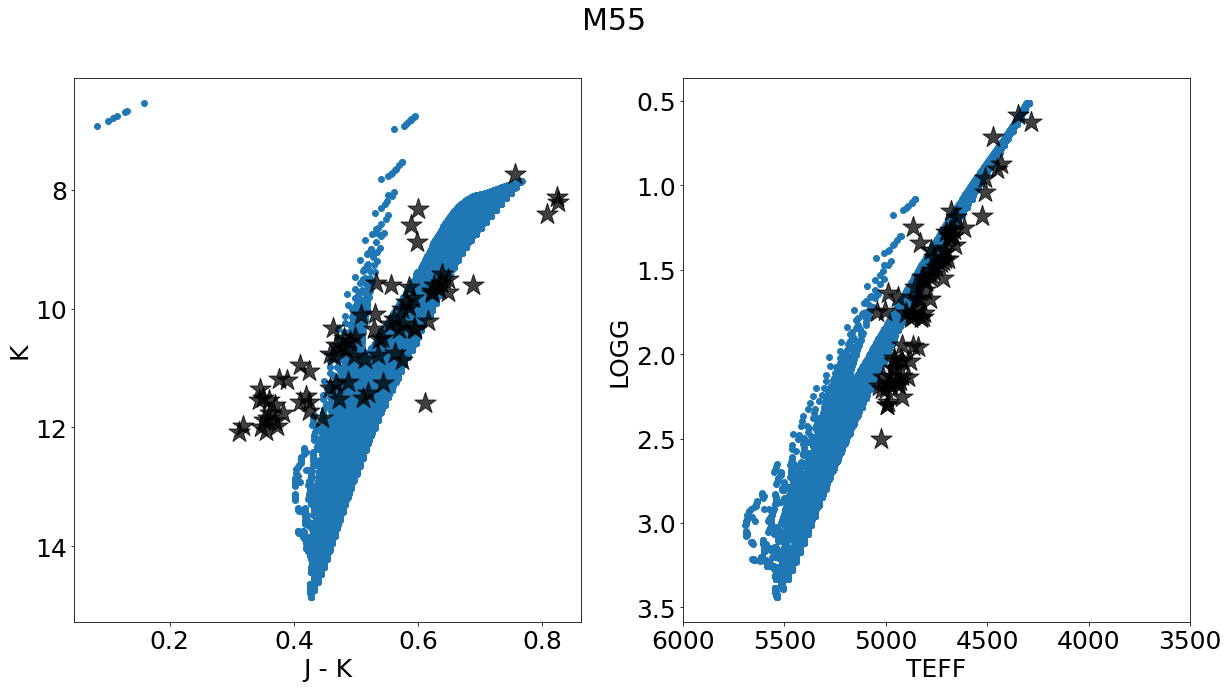

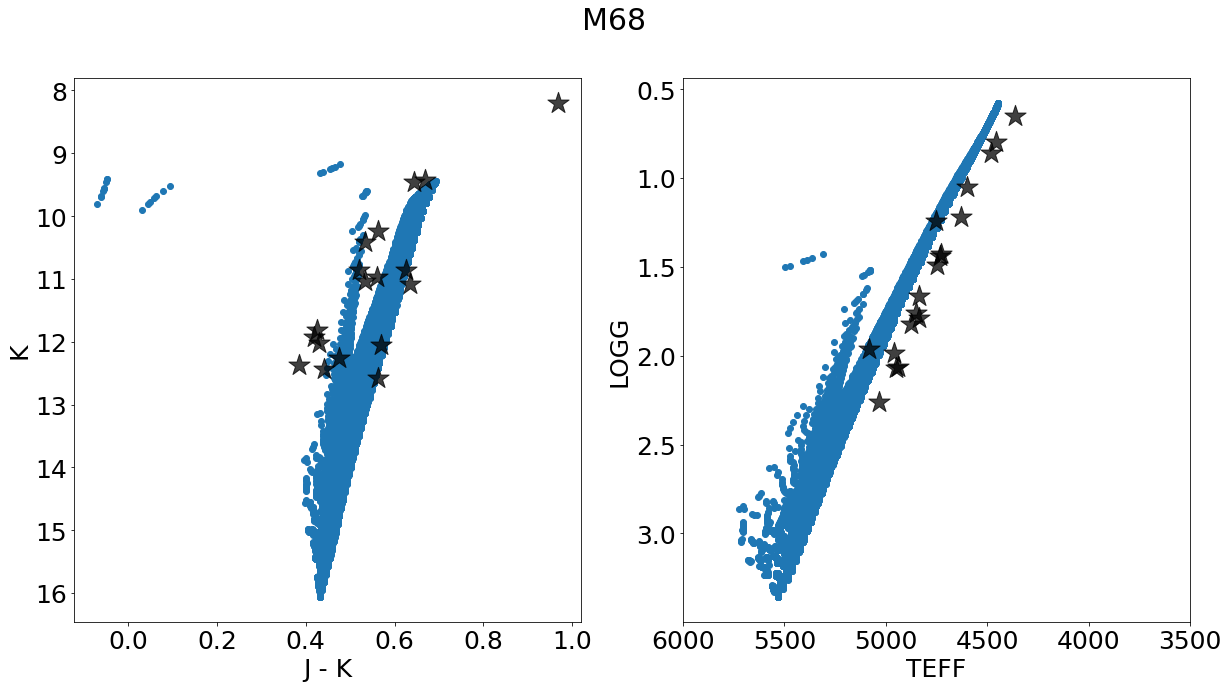

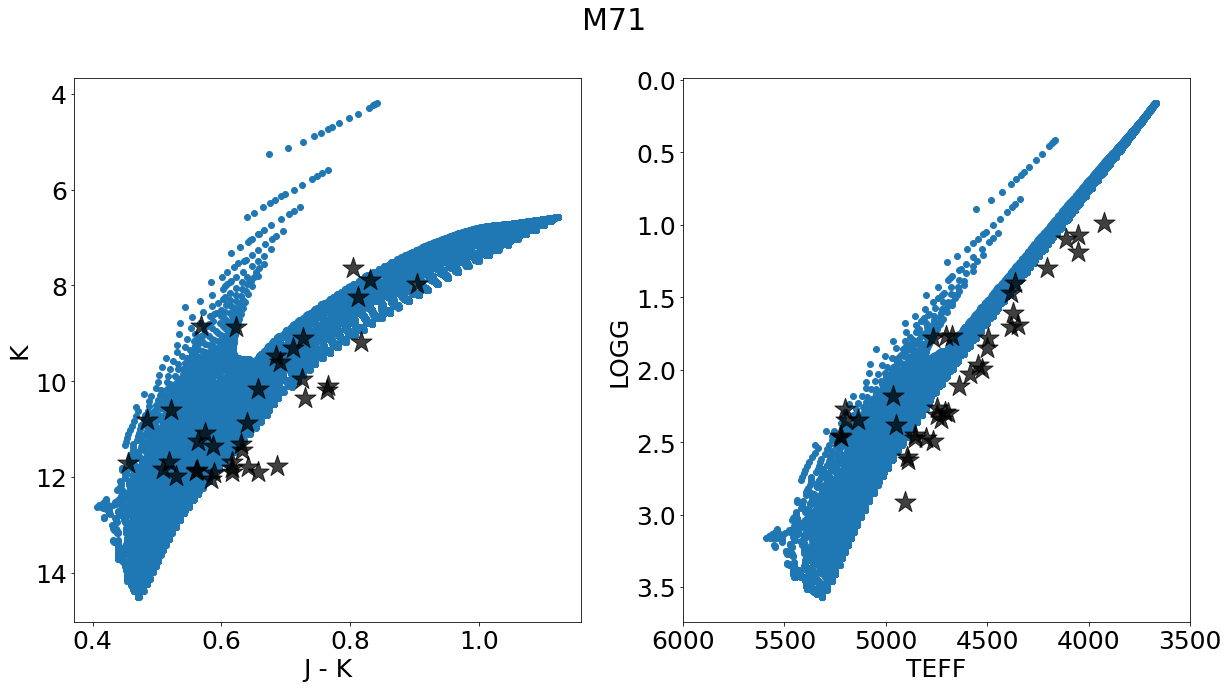

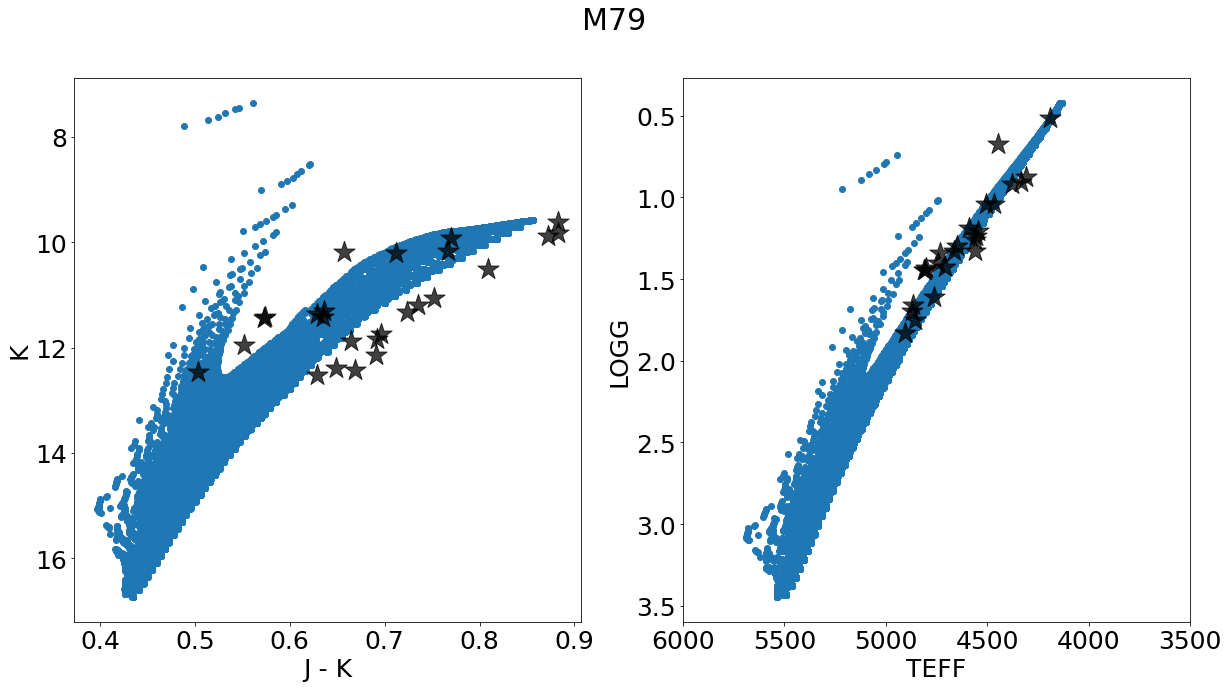

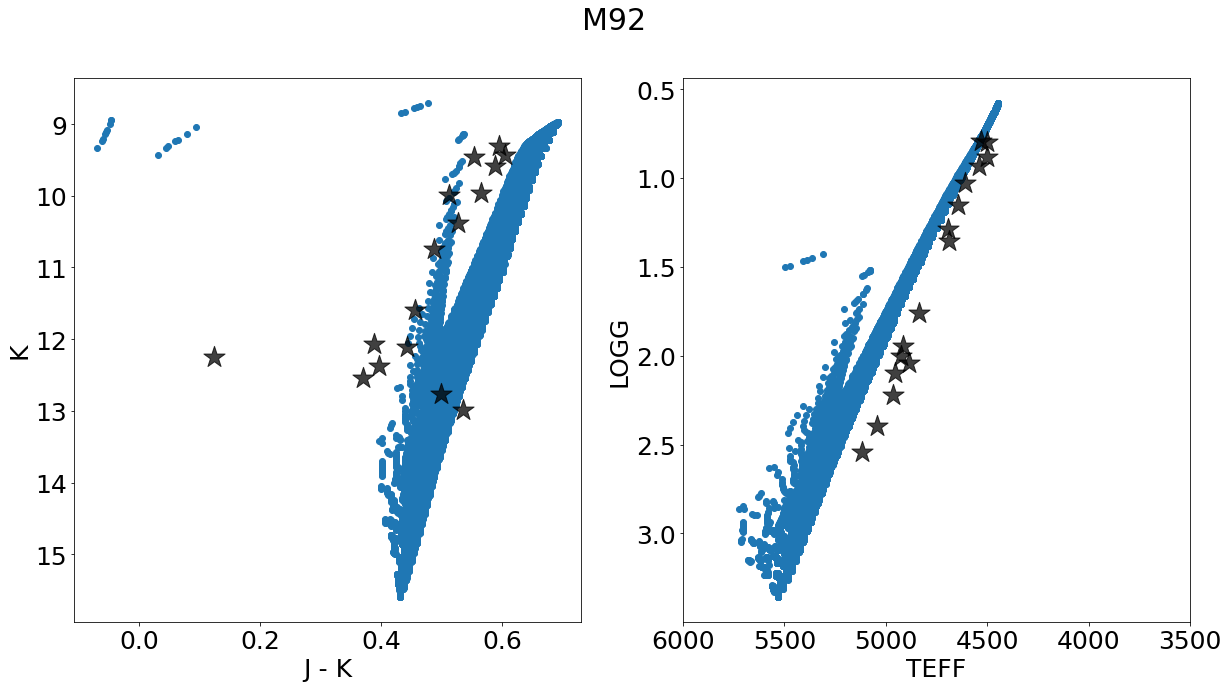

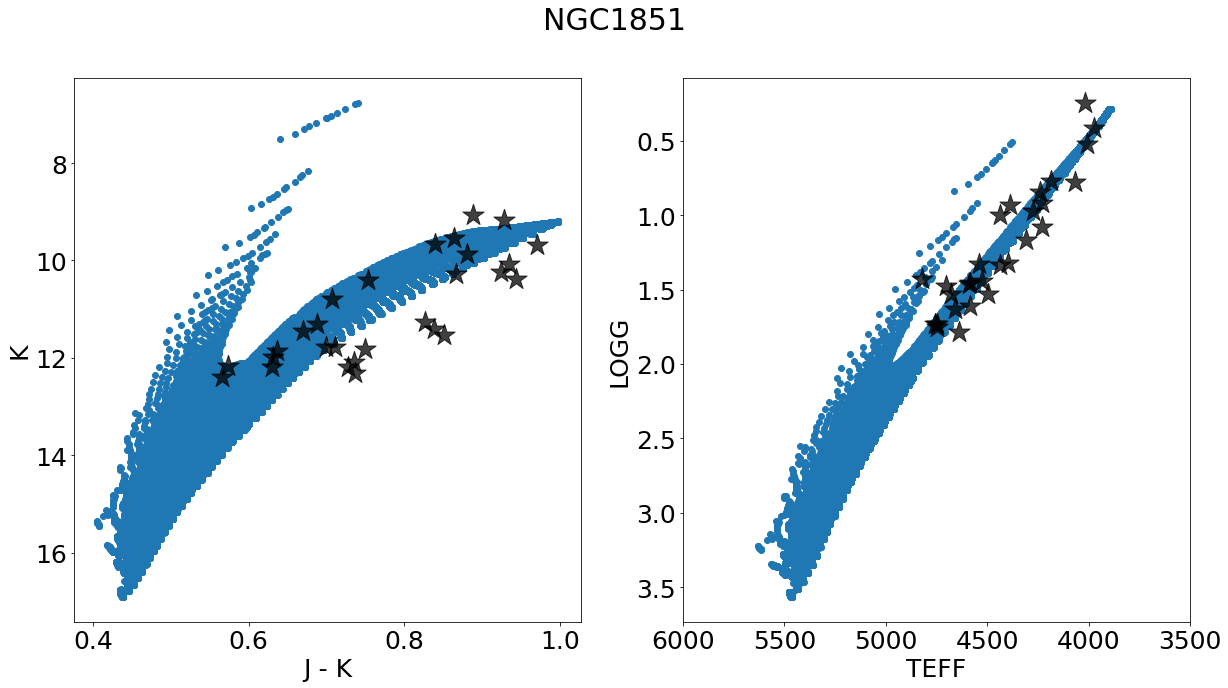

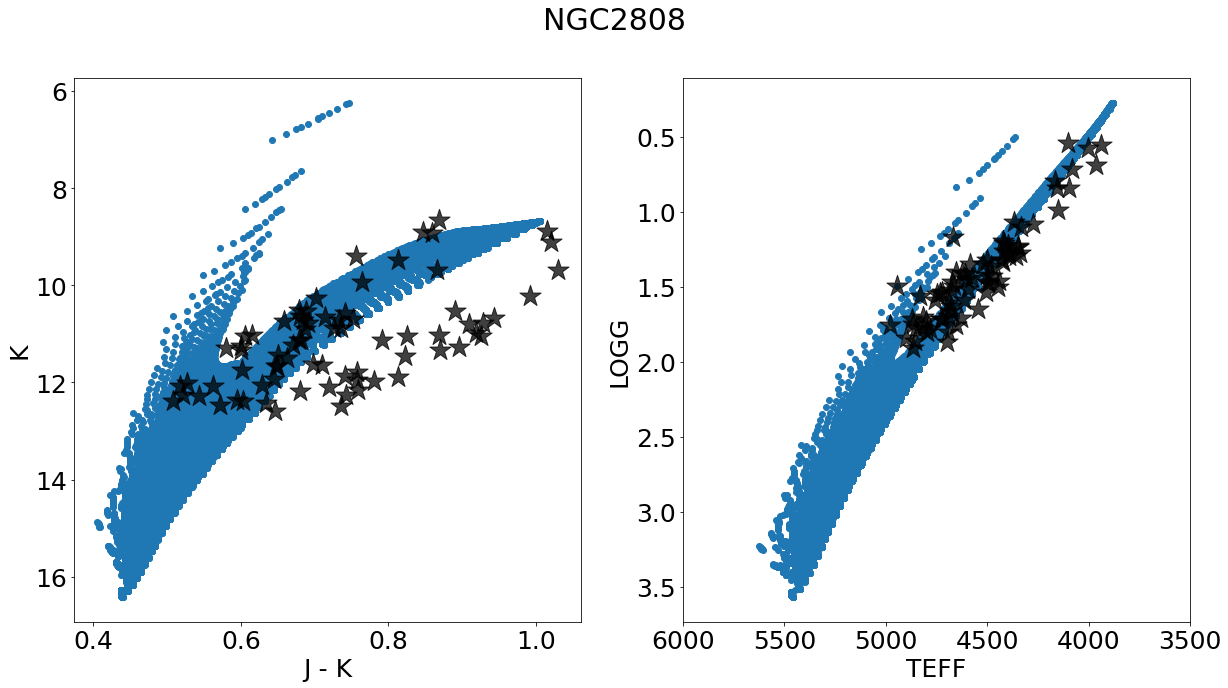

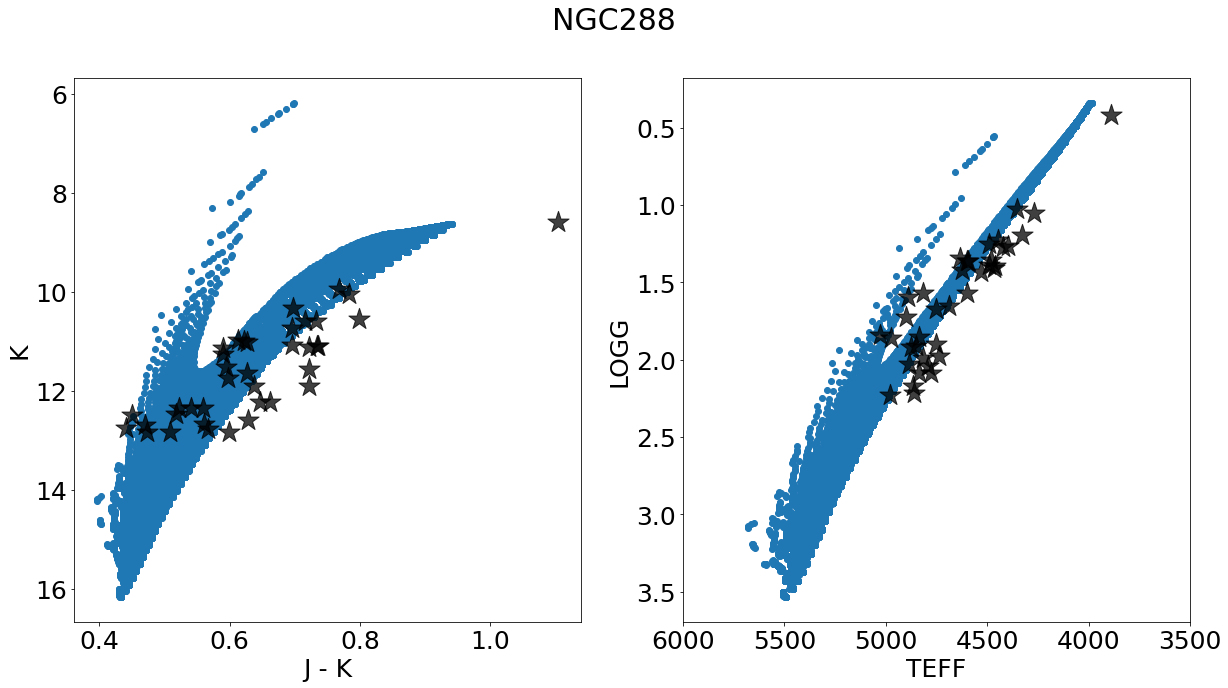

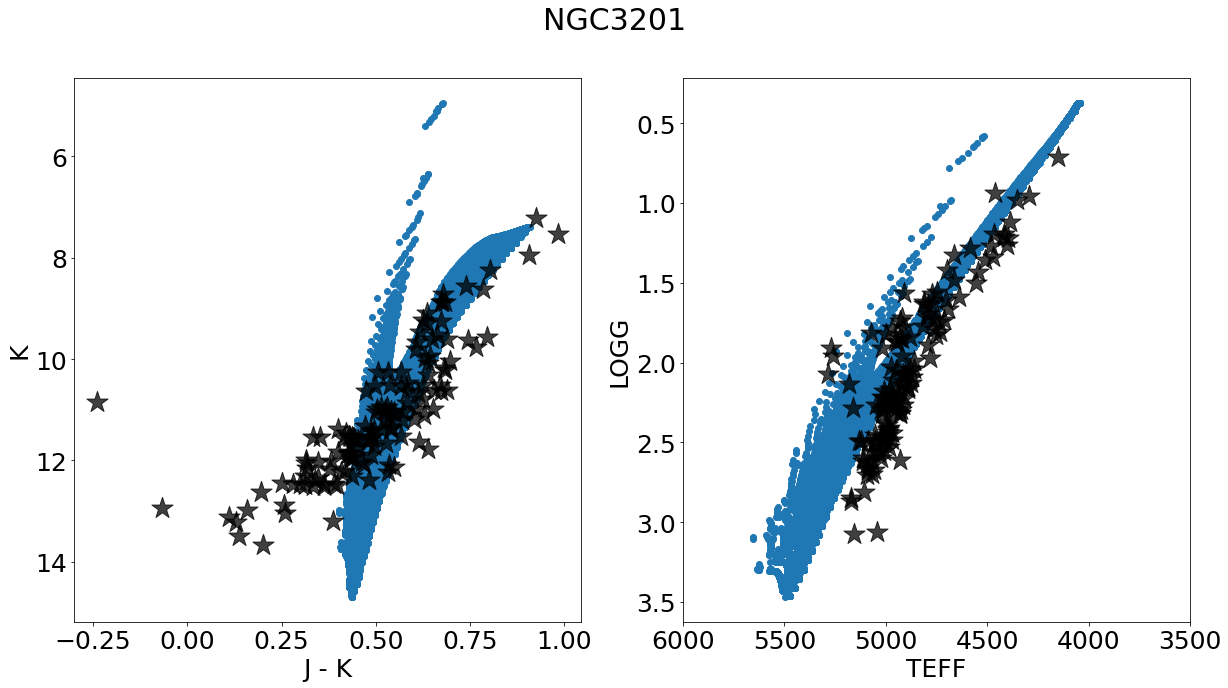

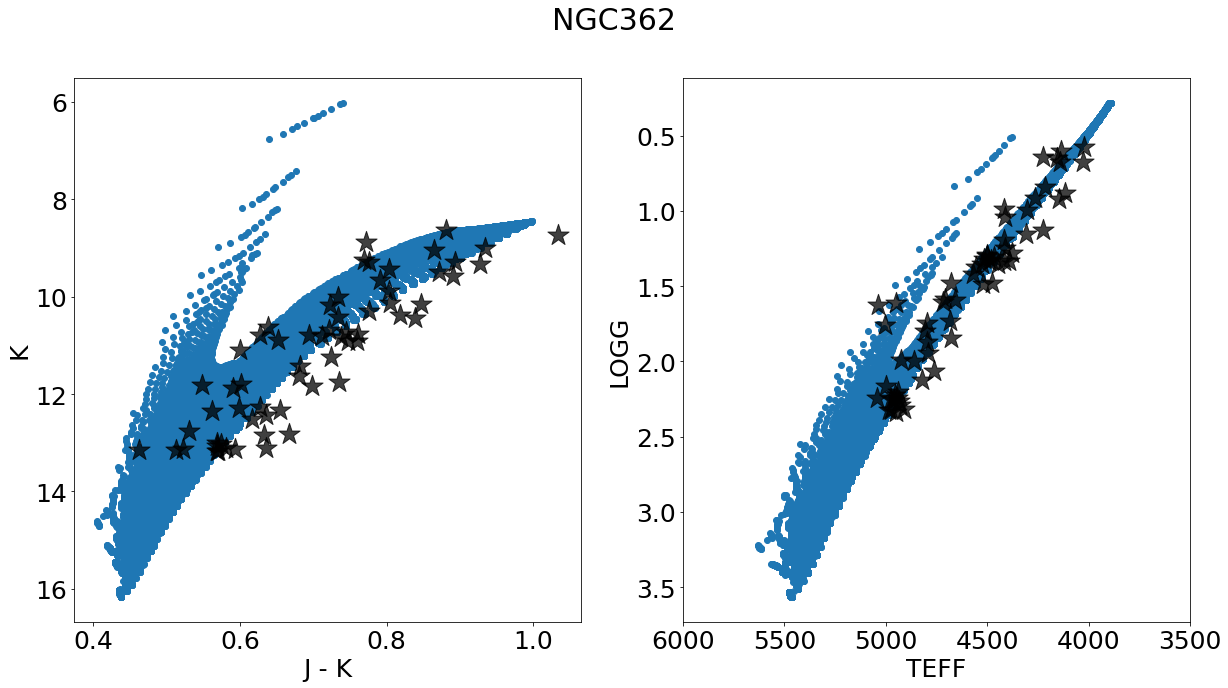

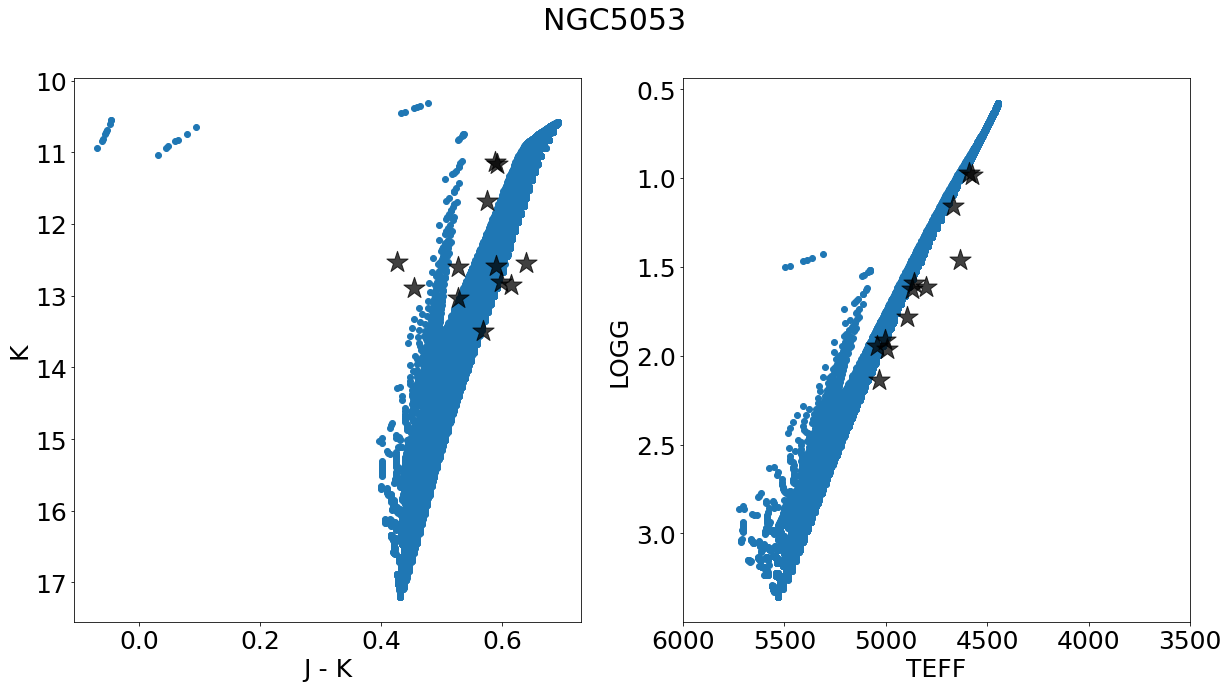

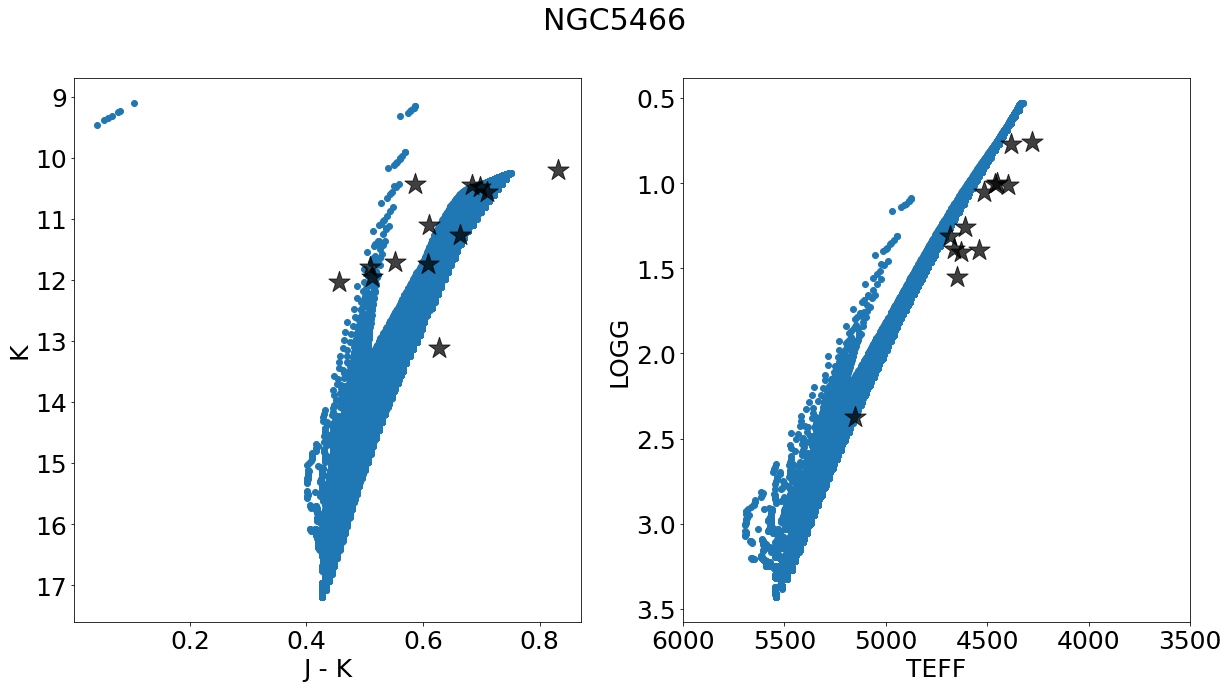

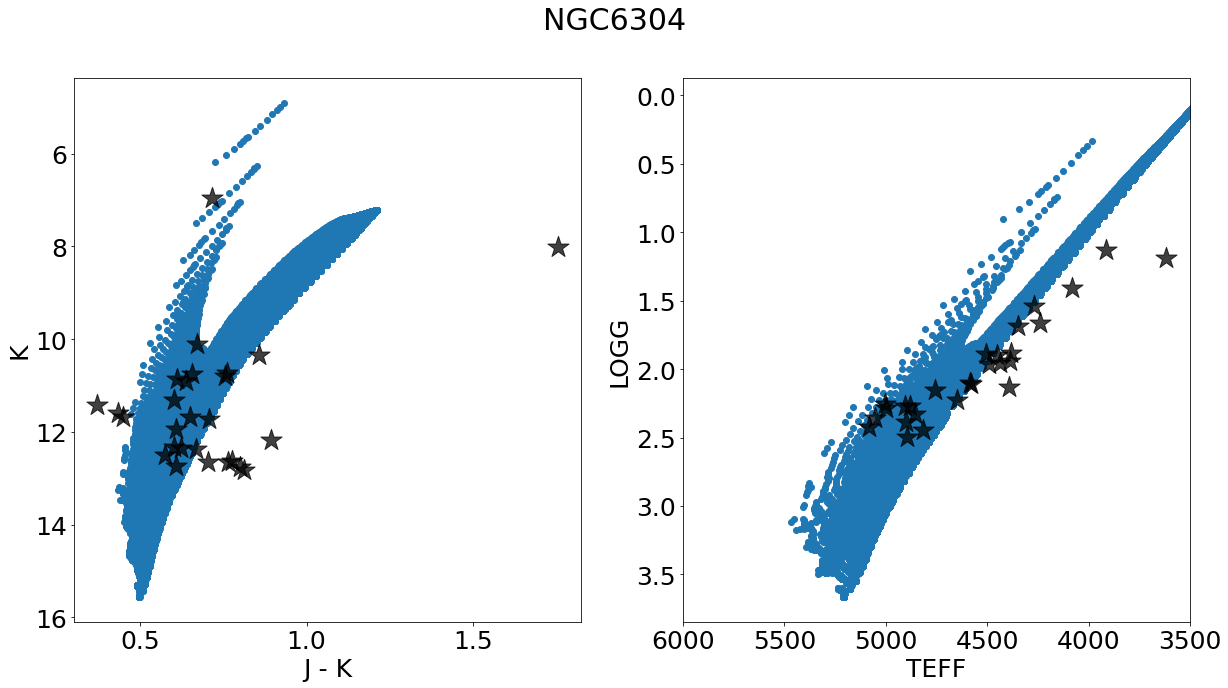

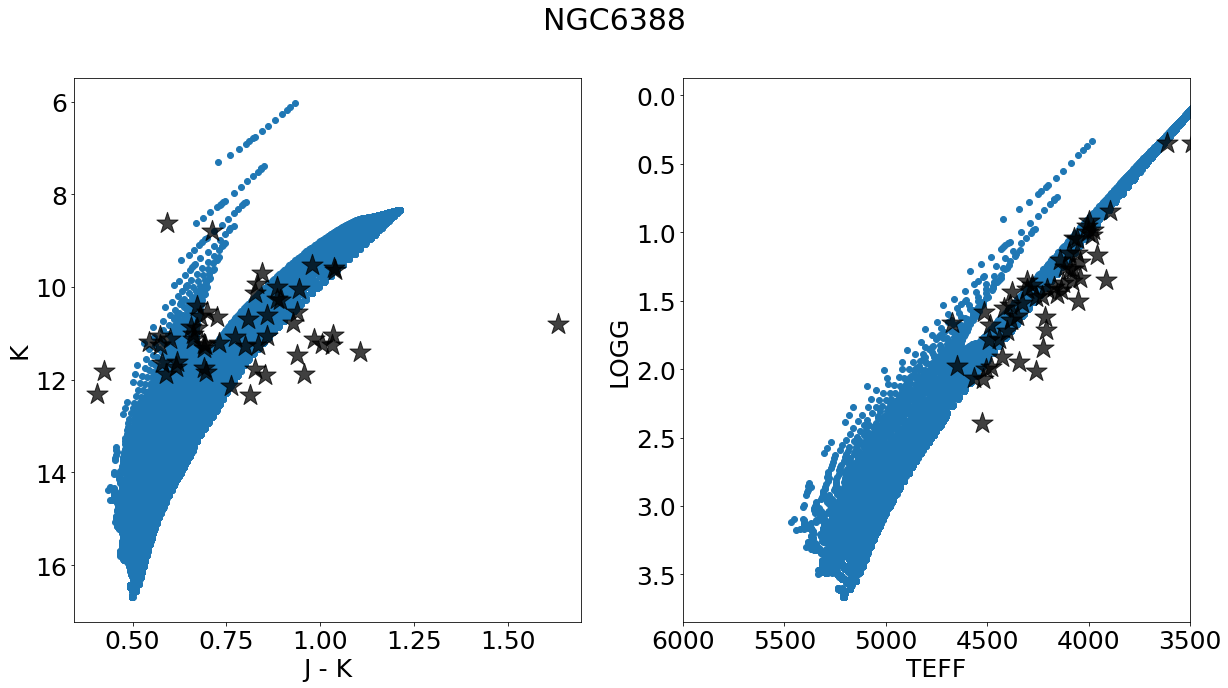

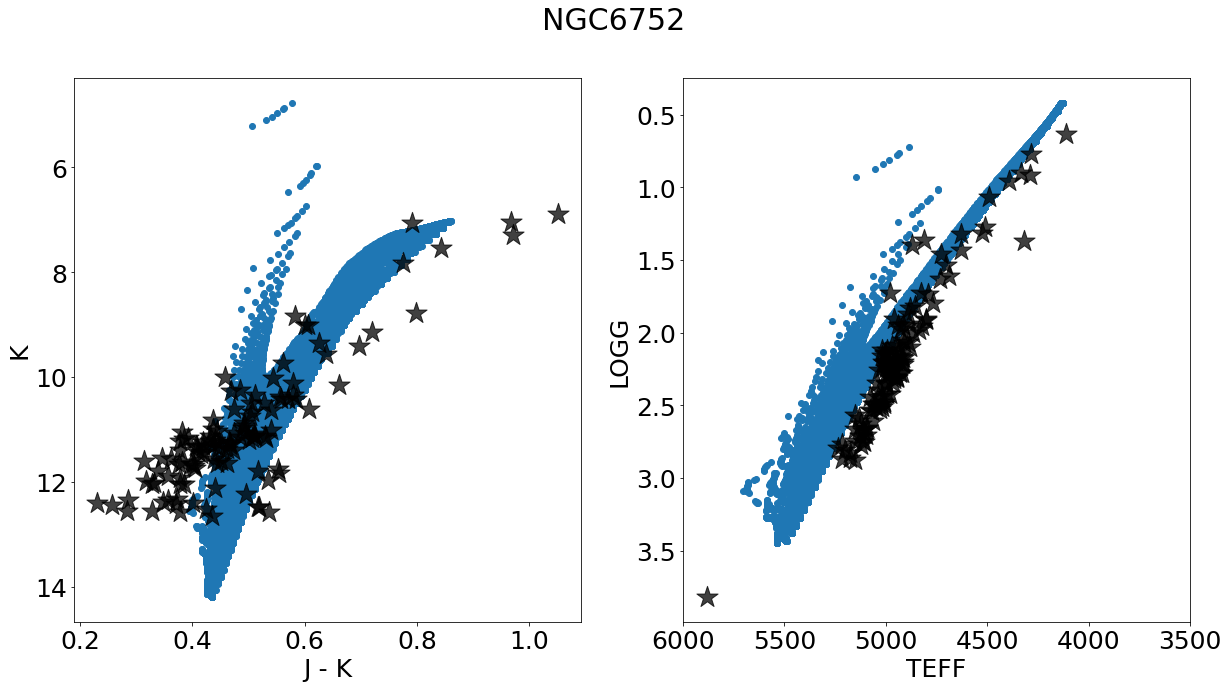

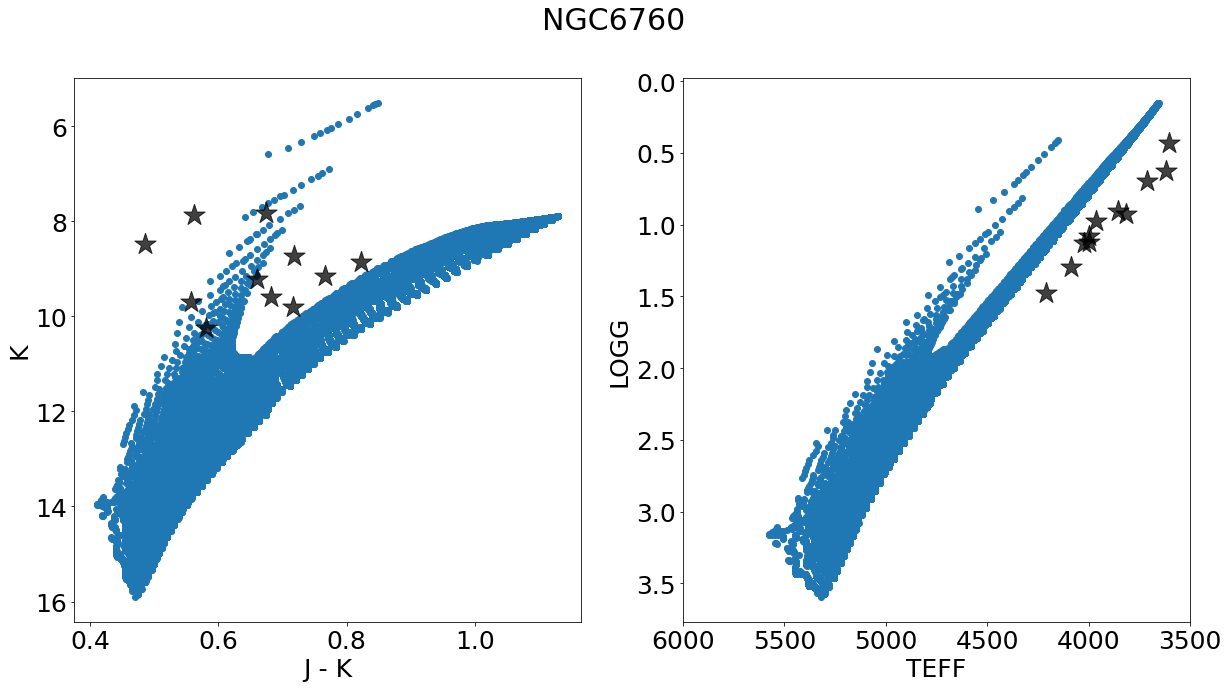

In [66]:
for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(best_aks!=999999.0))
    isopick = np.where(massive['MH']==closest(massive['MH'],np.median(shiftfeh[clus])))
    
    fig, ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter((massive['Jmag']-massive['Ksmag'])[isopick],
                  massive['Ksmag'][isopick]+5.*np.log10(harris_dist[i])-5.0,cmap='tab20',zorder=0)
    ax[0].scatter((gcsdr17['J']-gcsdr17['K']-best_aks*ejk_ak)[clus],gcsdr17['K'][clus]-best_aks[clus],c='k',
                  marker='*',s=500,zorder=1,alpha=0.75)
    ax[0].invert_yaxis()
    ax[0].set_xlabel(r'J - K')
    ax[0].set_ylabel(r'K')
    
    ax[1].scatter(10**massive['logTe'][isopick],massive['logg'][isopick],cmap='tab20',zorder=0)
    ax[1].scatter(gcsdr17['TEFF'][clus],gcsdr17['LOGG'][clus],c='k',marker='*',s=500,zorder=1,alpha=0.75)
    ax[1].set_xlim(3500,6000)
    ax[1].set_xlabel(r'TEFF')
    ax[1].set_ylabel(r'LOGG')
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    
    plt.suptitle(r'{}'.format(gcs_clus[i]))
#     plt.savefig('{}CMDHR.pdf'.format(gcs_clus[i]),bbox_inches='tight')
#     plt.title(r'K, J - K; {}; Color as Age'.format(gcs_clus[i]))
    plt.show()